In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, classification_report
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import tensorflow as tf

from src.model import MultiBinaryClassifier
from src.util import *

seed = 42
seed_everything(seed)
plt.rc('font', size=8)
plt.rc('axes', titlesize=8)
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-02-05 18:14:48.662347: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 18:14:48.662385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 18:14:48.663588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 18:14:48.670749: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 18:14:49.494951: W tensorflow/compiler/tf2

The aim of the project is to build a tool which can prevent a waste of computational resources preventing the execution of programmes that are likely to fail. In HPC centers, jobs are not executed at need, rather they follows a clear scheduling procedure which maximise efficiency. Further, also economic aspects should be taken into account during submission (more resources, higher cost). Therefore, during a job schedule, a set of parameters (e.g., number of cpu/gpu, quantity of memory, ecc.) must be specified in order to use the correct resources. These parameters are then used by the job scheduler to instantiate our work space. It's likely that, because a wrong configuration, a job can fail its run. 

Suppose that for a configuration error, a programmer specify a wrong amount of required memory, therefore, sooner or later, it's likely to fail. This, will first lead to a waste of computational time and resources for the HPC center (resources are limited and programs runs for a lot of time). Secondly, since companies pay a lot to use this systems, a substantial waste of money. Therefore, a system able to predict whether a job that will be scheduled is likely to fail could be very powerfull for both the sides.

# Data inspection & selection

Load the data and inspect them..

In [4]:
data = pd.read_parquet("data/job_table.parquet")
display(data.head(10))
print(f"Number of rows: {len(data)}")
print(f"Number of columns: {len(data.columns)}")
print(data.columns)

,pn_min_cpus,resize_time,ntasks_per_socket,tres_freq,comment,ntasks_per_socket_str,std_in,array_task_throttle,max_nodes,contiguous,...,cpus_allocated,billable_tres,last_sched_eval,eligible_time,power_flags,cores_per_socket,sockets_per_node,shared,cpus_per_task,req_nodes
0,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n04': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:05+00:00,0,,,OK,4,['r245n04']
1,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r250n19': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:10+00:00,0,,,OK,4,['r250n19']
2,32,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,"{'r212n10': 32, 'r212n15': 32, 'r212n14': 32, ...",256.0,2020-05-22T09:28:37.000Z,2020-05-22 09:28:37+00:00,0,,,OK,1,
3,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r209n15': 4},4.0,2020-05-22T20:39:06.000Z,2020-05-22 01:05:39+00:00,0,,,OK,4,['r209n15']
4,256,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,1,False,...,,,2020-05-22T18:56:39.000Z,2020-05-22 18:56:39+00:00,0,,,OK,32,
5,4,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n14': 4},4.0,2020-05-22T01:07:00.000Z,2020-05-22 01:06:06+00:00,0,,,OK,4,['r245n14']
6,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r226n11': 4},4.0,2020-05-22T10:41:04.000Z,2020-05-22 10:28:50+00:00,0,,,OK,1,['r226n11']
7,1,1970-01-01 01:00:00+00:00,,,,UNLIMITED,/dev/null,,0,False,...,{'r245n20': 4},4.0,2020-05-22T14:28:26.000Z,2020-05-22 10:29:02+00:00,0,,,OK,1,['r245n20']
8,4,1970-01-01 01:00:00+00:00,1.0,,,1,/dev/null,,0,False,...,{'r239n19': 4},4.0,2020-05-22T16:12:29.000Z,2020-05-22 16:12:28+00:00,0,,,OK,4,
9,128,1970-01-01 01:00:00+00:00,2.0,,,2,/dev/null,,0,False,...,{'r239n20': 128},128.0,2020-05-22T12:15:20.000Z,2020-05-22 12:15:19+00:00,0,,,OK,32,


Number of rows: 6236346
Number of columns: 100
Index(['pn_min_cpus', 'resize_time', 'ntasks_per_socket', 'tres_freq',
       'comment', 'ntasks_per_socket_str', 'std_in', 'array_task_throttle',
       'max_nodes', 'contiguous', 'max_cpus', 'resv_name', 'user_id',
       'tres_per_task', 'derived_ec', 'tres_per_socket', 'exc_nodes',
       'tres_req_str', 'array_job_id', 'boards_per_node', 'priority',
       'num_nodes', 'tres_per_node', 'cpus_alloc_layout', 'name',
       'run_time_str', 'array_task_str', 'time_min', 'time_limit_str',
       'end_time', 'year_month', 'alloc_sid', 'mem_per_cpu', 'req_switch',
       'show_flags', 'group_id', 'wait4switch', 'array_task_id', 'exit_code',
       'mem_per_node', 'restart_cnt', 'requeue', 'tres_bind', 'profile',
       'batch_flag', 'plugin', 'work_dir', 'pn_min_memory', 'nice',
       'ntasks_per_node', 'ntasks_per_core_str', 'accrue_time',
       'tres_alloc_str', 'nodes', 'sockets_per_board', 'std_out',
       'array_max_tasks', 'job_id',

The dataset contains a huge set of jobs, each with a wide variety of features. Most of them are unusable for our task, beacuse they are unavailable at submission time. Other are too specific, so most of the times have a default value. So, after reading the job scheduler handbook, we select a very reduced subset of features. Then, we use it trying to extract some relevant correlations, if they exists, with a job failure. 

In [5]:
print(f"Job states: {data['job_state'].unique()}")

Job states: ['COMPLETED', 'CANCELLED', 'FAILED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL', 'PREEMPTED']
Categories (7, object): ['COMPLETED', 'CANCELLED', 'FAILED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL', 'PREEMPTED']


Among all the A possible job's exite state, we only consider the following possibilities: COMPLETED, FAILED, OUT_OF_MEMORY, TIMEOUT. We discard CANCELLED and NODE FAIL states, beacuse they happen for reasons not dependent on the job itself (crash of system partition, highest priority job must run, ecc). 

We also apply a filter on the feature **tres_req_str** to reduce computational time, taking subset of about one sixth of the original.

In [6]:
columns = ["submit_time", "user_id", "group_id", "name", "command", "partition", "priority",
           "qos", "time_limit", "cpus_per_task", 'num_tasks', "tres_req_str", "job_state"]

df = data[columns]
df = df[df.tres_req_str != ""]
df = df[(df.job_state != "CANCELLED") & (df.job_state != "NODE_FAIL")]
df.reset_index(drop=True, inplace=True)
df

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016525,2020-10-08 20:31:23+00:00,32588,25200,sire_pjc,/m100_work/hpce3_Tosco/WANG_FULL_OFF_121/RERUN...,m100_usr_prod,297707,normal,720,1,4,"cpu=4,mem=8000M,node=1,billing=4,gres/gpu=1",COMPLETED
1016526,2020-10-09 05:18:51+00:00,31392,25200,praAnt-run4-2m,/m100_work/IscrB_INwARDS_0/NR/NR3/PRant-Run4/r...,m100_usr_prod,145536,normal,1440,32,4,"cpu=128,mem=237.50G,node=1,billing=128,gres/gpu=4",COMPLETED
1016527,2020-10-09 10:20:40+00:00,26429,25200,job_density.sh,/m100_scratch/userexternal/mfarnesi/CP2K_Inter...,m100_usr_prod,917,qos_lowprio,60,32,4,"cpu=128,mem=230000M,node=1,billing=128,gres/gpu=4",FAILED
1016528,2020-10-09 01:36:42+00:00,32232,25200,script.marconi100.x,/m100/home/userexternal/nthomopu/script.marcon...,m100_usr_prod,330946,normal,10,1,8,"cpu=8,mem=7100M,node=1,billing=8,gres/gpu=1",COMPLETED


Inspect the presence of missing values

In [7]:
# in the dataset missing values are empty string, we convert it to nan to count them
df = df.replace('', np.nan)
print(df.isna().sum())
prev_len = len(df)

df = df.dropna().reset_index(drop=True)
print(f"Num of rows: {len(df)}")
print(f"Dropped rows: {prev_len - len(df)} ({(1-(len(df)/prev_len)):.1%})")

submit_time          0
user_id              0
group_id             0
name                 0
command           3584
partition            0
priority             0
qos                  0
time_limit           0
cpus_per_task        0
num_tasks        37945
tres_req_str         0
job_state            0
dtype: int64
Num of rows: 975170
Dropped rows: 41360 (4.1%)


We cannot deal with missing values and sometimes replace it with some default values cannot be the best choice. As they are very few, we decide to drop them. 

At the end, save the dataset for the future usage.

In [8]:
df.to_pickle("data/job_table_reduced.pkl")
del data 
del df

# Data Preprocessing

In [9]:
df =pd.read_pickle("data/job_table_reduced.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,2020-05-22 01:06:05+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,87034,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,2020-05-22 01:06:10+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,85884,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,2020-05-22 01:05:39+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,115982,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,2020-05-22 18:56:39+00:00,32152,25200,CBC,/m100_scratch/userexternal/squlagha/CaB3C3/job...,m100_usr_prod,80216,normal,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,2020-05-22 01:06:06+00:00,32171,25200,slurm_multinode_prova,/m100_scratch/userinternal/nshukla1/stream_CPU...,m100_usr_prod,86934,normal,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


As you can see, not all the faetures are numeric, but there are a lot of string data and date. This type of datas don't suit in learning algorithm, so fix it.

For dates, we convert it to a timestamp ending with a numeric representation of when the job was submitted.

In [10]:
df['submit_time'] = df['submit_time'].apply(lambda x: x.timestamp()).astype(np.int64)

Exist a large variety of tecniques to convert strings into numeric format. Following the Occam's razor, we use the easiest which it consists to convert each string into a number.  

In [11]:
text_columns = ["name", "command", "partition", "qos"]
ord_enc =  OrdinalEncoder(dtype=np.int64)
for col in text_columns:
    val = df[col].values.reshape(-1, 1)
    df[col] = ord_enc.fit_transform(val)
print(f"Text columns transformed: {text_columns}")

df[df.columns[1:-2]] = df[df.columns[1:-2]].apply(pd.to_numeric)

display(df.head())
for col in text_columns:
    print(f"Number of unique values in {col} columns: {len(df[col].unique())}")

Text columns transformed: ['name', 'command', 'partition', 'qos']


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,tres_req_str,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,"cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1",FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,"cpu=4,mem=246000M,node=1,billing=4",COMPLETED


Number of unique values in name columns: 78586
Number of unique values in command columns: 238768
Number of unique values in partition columns: 4
Number of unique values in qos columns: 8


By looking the above values, we can say that for **partition** and **qos** columns integer encodig is perfect due their low number of unique values. For the other 2 instead, it may be the case to find a better way in the feature to improve performance.

Now, for the **tres_req_str** we decide to split this column into 5 different columns: **req_cpu**, **req_mem**, **req_node**, **req_billing**, **req_gpu**. Each column is been filled with the value after the "=" and if not present with a 0. An example of string is and the corresponding splittig is:<br><br>
cpu=256,mem=230000M,node=1,billing=256,gres/gpu=1
| req_cpu | req_mem | req_node | req_billing | req_gpu |
|---------|---------|----------|-------------|---------|
| 256     | 230000  | 1        | 256         | 1       |

In [12]:
labels = df.pop("job_state")

fields = ["req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]
req_str = df.pop('tres_req_str')
df[fields] = req_str.str.split(',', n=5, expand=True)
for f in fields:
    df[f] = df[f].apply(lambda c: re.sub("[a-zA-Z=/]", "", c) if c is not None else 0)

df[fields] = df[fields].apply(pd.to_numeric)
df["req_mem"] = df["req_mem"].apply(lambda v: round(v, 0)).astype(np.int64)  
    
df["job_state"] = pd.Categorical(list(labels))
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000,1,4,0,COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000,1,4,0,COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000,1,4,0,COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000,1,256,1,FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000,1,4,0,COMPLETED


Save the data for the future.

In [13]:
df.to_pickle("data/job_table_preproc.pkl")
del df

# Data Anlaysis

In [14]:
df = pd.read_pickle("data/job_table_preproc.pkl")
df.head()

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu,job_state
0,1590109565,32171,25200,77949,62668,3,87034,4,10,4,1,4,246000,1,4,0,COMPLETED
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000,1,4,0,COMPLETED
2,1590109539,32171,25200,77949,62085,3,115982,4,10,4,1,4,246000,1,4,0,COMPLETED
3,1590173799,32152,25200,30918,51406,3,80216,4,360,32,8,256,230000,1,256,1,FAILED
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000,1,4,0,COMPLETED


Print some data statistics, we exclued user, group info and job name and command beacuse as they are integer encodig of strings their statistics are not relevant

In [15]:
feature_to_describe = ["submit_time", "qos", "time_limit", "cpus_per_task", "num_tasks",
                        "req_cpu", "req_mem", "req_node", "req_billing", "req_gpu"]

df[feature_to_describe].describe().T

,count,mean,std,min,25%,50%,75%,max
submit_time,975170.0,1.597577e+09,4.074300e+06,1.589838e+09,1.592478e+09,1.599163e+09,1.601697e+09,1.602575e+09
qos,975170.0,3.983316e+00,3.737666e-01,0.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,7.000000e+00
time_limit,975170.0,1.063604e+03,5.112179e+02,1.000000e+00,7.200000e+02,1.440000e+03,1.440000e+03,1.440000e+03
cpus_per_task,975170.0,1.330155e+01,1.625014e+01,1.000000e+00,1.000000e+00,2.000000e+00,3.200000e+01,4.444000e+03
num_tasks,975170.0,1.652385e+01,1.609270e+02,0.000000e+00,4.000000e+00,4.000000e+00,2.400000e+01,3.276800e+04
req_cpu,975170.0,1.148630e+02,6.219569e+02,1.000000e+00,4.000000e+00,2.400000e+01,1.280000e+02,6.553600e+04
req_mem,975170.0,9.824427e+04,5.347606e+05,1.000000e+00,2.380000e+02,8.000000e+03,8.600000e+04,5.796000e+07
req_node,975170.0,1.724648e+00,7.200674e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.560000e+02
req_billing,975170.0,1.148630e+02,6.219569e+02,1.000000e+00,4.000000e+00,2.400000e+01,1.280000e+02,6.553600e+04
req_gpu,975170.0,4.596272e+00,2.751967e+01,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,1.024000e+03


From the above statistics, we can highlight:
1. data are neither normalized nor standardized
2. *qos* column have values very close to the mean, looking the std
3. half of the job have the maximum time limit
4. all the req features have values very smaller rather than the max, it mean that bigger values are outliers

Now, plot job's exit state statistics
<a id='job_state_dist'></a>

job_state
COMPLETED        0.879829
FAILED           0.101628
TIMEOUT          0.014265
OUT_OF_MEMORY    0.004277
Name: proportion, dtype: float64


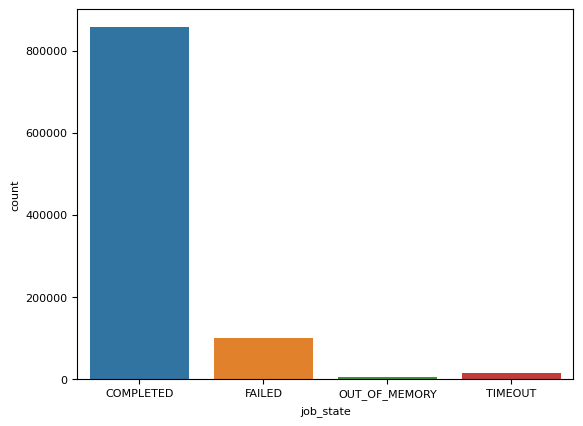

In [16]:
sns.countplot(df, x="job_state", hue="job_state")
print(df.job_state.value_counts(normalize=True))

The dataset is unbulanced. We expected it since we are working with HPC's executed jobs and the presence of many failed would represent a big problem for the system.

Plot the distribution of all dataset's features.

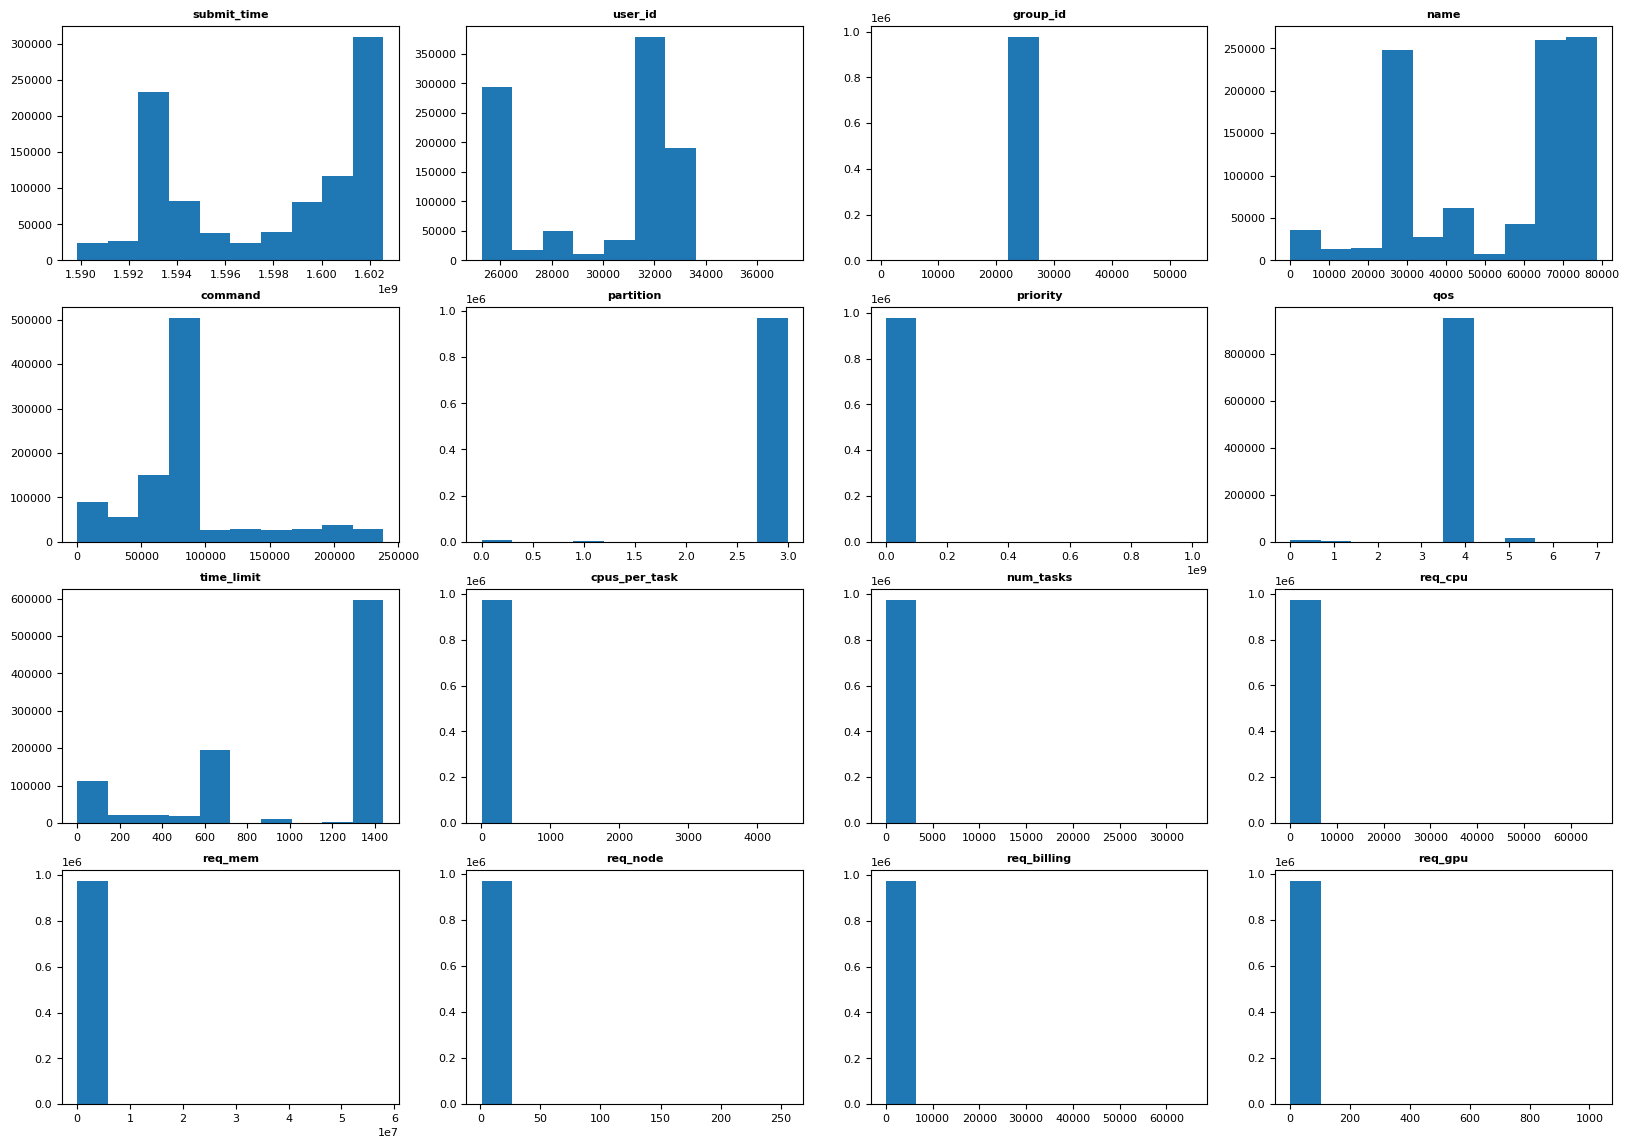

In [17]:
cols = df.select_dtypes(include="int64").columns
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
i, j = 0, 0
for col in cols:
    counts, edges, bars = axs[i, j].hist(df[col])
    axs[i, j].set_title(col, fontweight="bold")
    j+=1
    if j%4 == 0:
        j = 0
        i +=1
plt.show()

There are values that are much more frequent rather than others, this means that outliers are infrequent.

Plot the correlation and try to extract some information on the data.

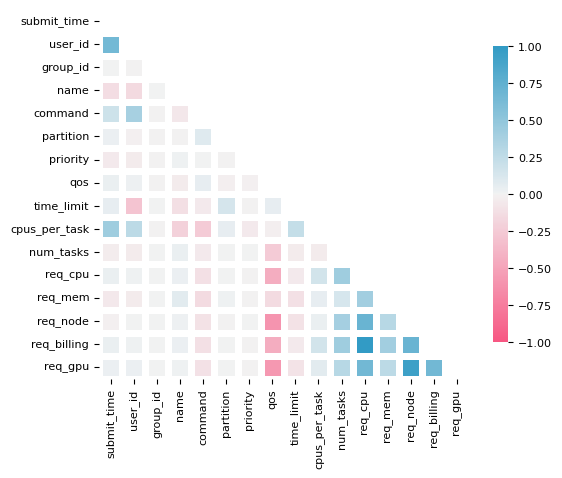

In [18]:
corr_matrix=df.select_dtypes(include=['int64']).corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, square=True, cmap=cmap,
            vmin=-1, vmax=1, linewidths=5, cbar_kws={"shrink": .8})
plt.show()

From the plot above we can identify some interesting patters: the number of requested cpus is directly proportional to nuber of nodes and inversely to the qos.

Each node has a number of processors, so higher values of requested cpus need more nodes. The qos behavior can be due to a likely premption or rescheduling pf a job with many resources. Additionally, reading the Slurm documentation, qos parameter spcify also job's resource limits. It could be the case that some failed jobs have qos to low and they request to much resources.

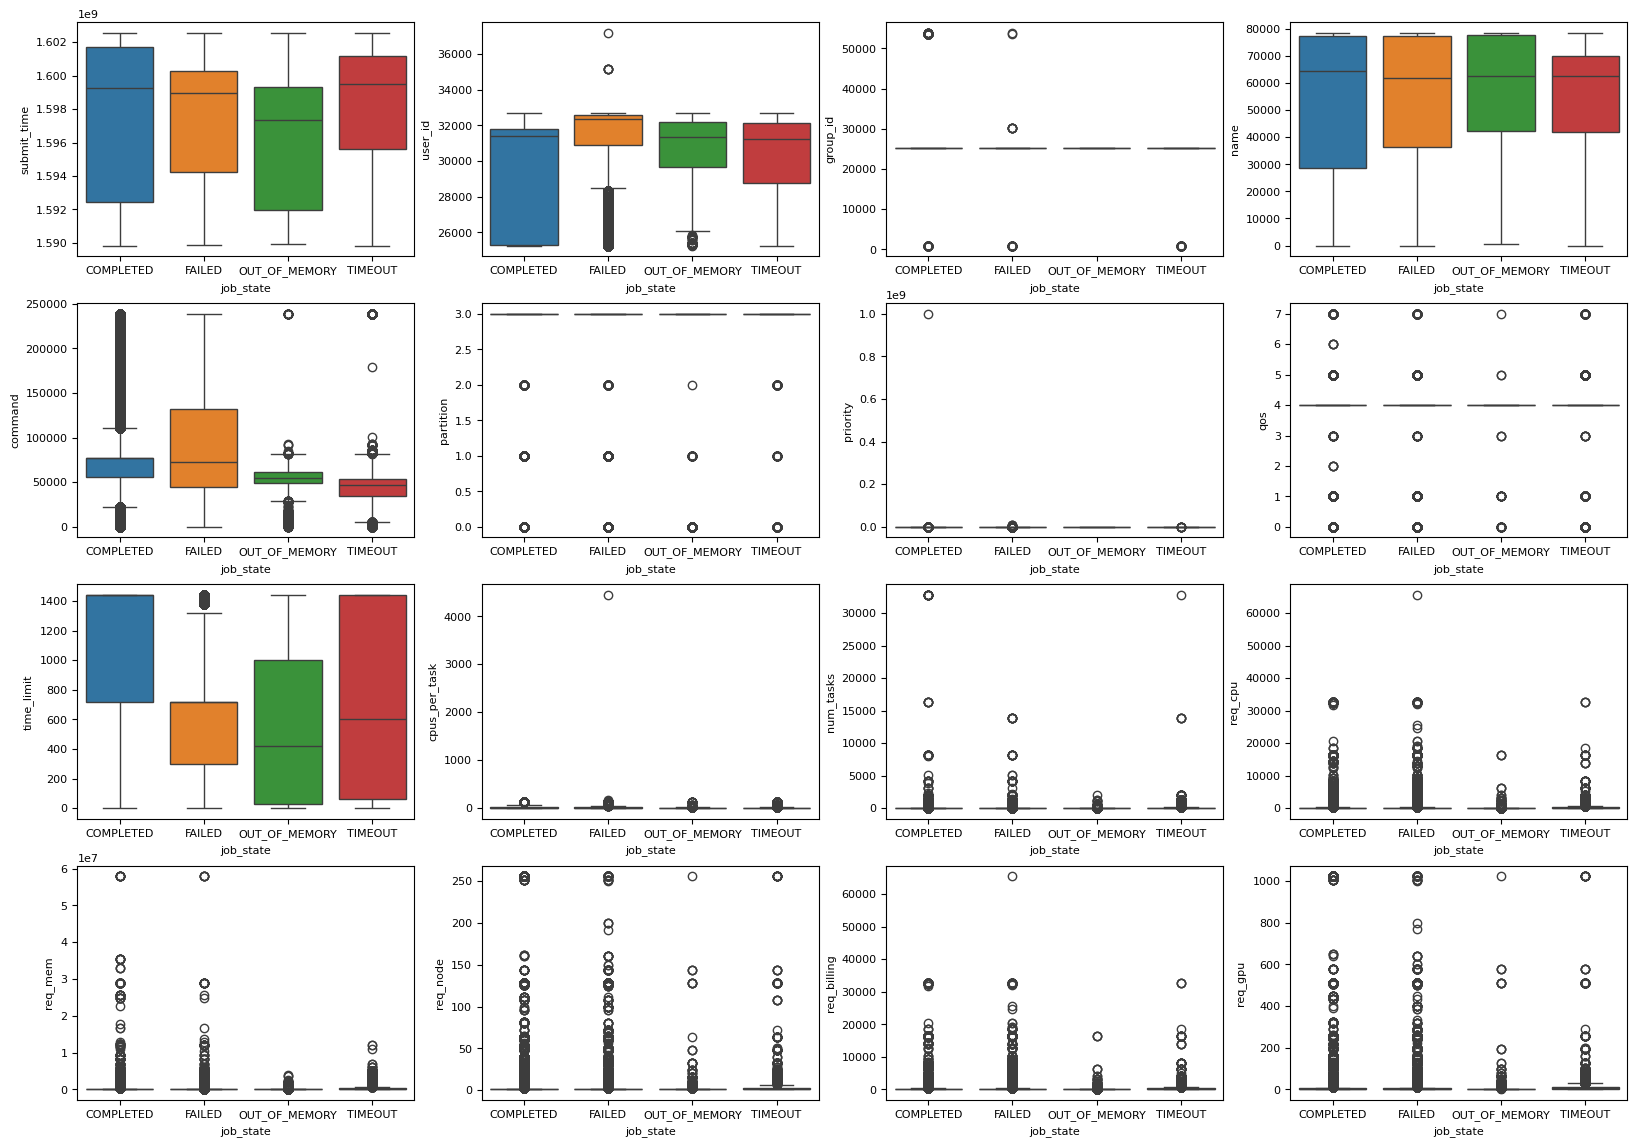

In [19]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))

i, j = 0, 0
for col in df.columns:
    if col != "job_state":
        sns.boxplot(df, x="job_state", y=col, hue="job_state", ax=axs[i, j])
        j+=1
        if j%4 == 0:
            i+=1
            j=0
plt.show()

Looking the plots above, we cannot exctrat any usefull information on which data are distributed among job state possibilities.

# Job Exit State prediction

The Exist State is a string which represents that status of a completed program run. According to our dataset, it can be one of the following 4 possibilities:
1. **COMPLETED**: the execution ends correctly
2. **FAILED**: the execution ends with a general error. It can be due to several motivations such as error in code, missing I/O, ecc.
3. **OUT OF MEMORY**: the execution is interrupted causes memory saturation
4. **TIME OUT**: the execution time exceed the time limit, so the job's run is interrupted.

## Binary


As described above, our task is to create a system which takes as input jobs' submission parameters and predict what exit state is more likely to happen. As first attempt, we focused only on classify whether a job  is completed or not. We firstly binirize our data, converting other fails states into *FAILED*. Secondly, we assign to each job integer label in the following way:
 - **0**: for completed job
 - **1**: for those failed


In [10]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print()
print("Old labels: ", np.unique(labels))

labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

print("New labels: ", list(np.unique(labels)))

Loading data... Lodaded!

Old labels:  ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']
New labels:  ['COMPLETED', 'FAILED']


Encode labels with integer values

In [11]:
lab_enc = {"COMPLETED": 0, "FAILED": 1}

print(f"Old values: {labels[:5]}")
labels = np.asarray([lab_enc[l] for l in labels])
print(f"New values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
New values: [0 0 0 1 0]


Split the data into train and test sets and normalize using only train information

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_train)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
train data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
train labels shape: 546095
test labels shape: 292551


In [14]:
train_dist = dict(Counter(y_train))
val_dist = dict(Counter(y_val))
test_dist = dict(Counter(y_test))

for cls_name,val in lab_enc.items():
    print(f'Class: {cls_name}')
    print(f" - train:\t{train_dist[val]/len(y_train):.3f}")
    print(f" - val:\t\t{val_dist[val]/len(y_val):.3f}")
    print(f" - test:\t{test_dist[val]/len(y_test):.3f}")

Class: COMPLETED
 - train:	0.879
 - val:		0.879
 - test:	0.881
Class: FAILED
 - train:	0.121
 - val:		0.121
 - test:	0.119


The distributions remain the same across the sets.

Because of the high imbalance in the dataset, we try to improve performance weighing classes to correct the unbulance

In [15]:
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {k:v for k,v in enumerate(class_weight)}
class_weight

{0: 0.5685303444527963, 1: 4.148019019840185}

### Regression

We are working on a binary classification task, so the possibility for a job exit state are only 2: completed or not. The simplest way to address this task is with a regression. **Logistic Regression** is the regression applied when the outcome is bounded betwen 0 and 1. The idea is simply, try to lineraly seprate data points, in the features space. 

Create our regressor and look how it performs.

F1:		train=0.246, validation=0.247
Recall:		train=0.448, validation=0.449
Precision:	train=0.122, validation=0.122


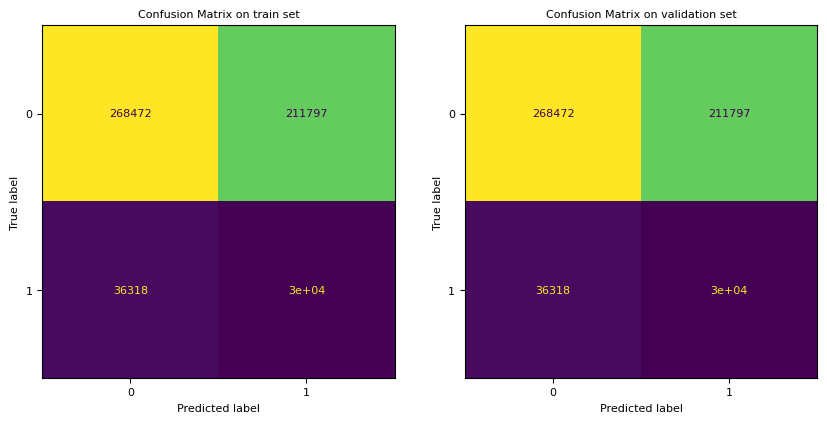

In [26]:
reg = LogisticRegression(class_weight=class_weight, random_state=seed, n_jobs=-1)
reg.fit(x_train, y_train)
evaluate_model(reg, x_train, y_train, x_val, y_val)

Very bad performance. Data points are not separable. Therefore, we decide to not tune the model.

### Classification

#### Decision Tree

We are working with tabular data and with this type of data the relation between features is very important. One of the simplest but powerfull classification tools are so called CART algorithms. **Decision Trees** is one of them. It's very powerfull for many reason including speed, explainability, reliability, simplicity it become a milestone for Machine Learning. They work building a decision tree from the root to the leaf, where each leaf is an output class value.

Let's how its perform on our data

F1:		train=0.930, validation=0.828
Recall:		train=0.986, validation=0.869
Precision:	train=0.826, validation=0.747


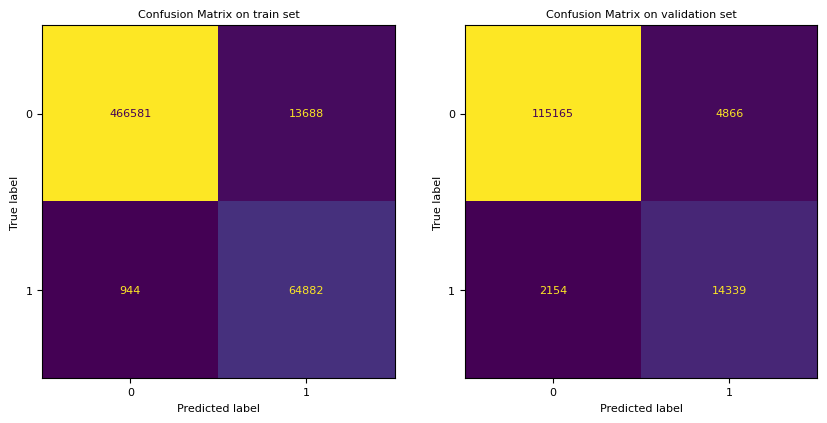

In [7]:
dt_bin = DecisionTreeClassifier(class_weight=class_weight, random_state = seed)
dt_bin = dt_bin.fit(x_train, y_train)
evaluate_model(dt_bin, x_train, y_train, x_val, y_val)

Pretty good results on the validation set. However, there is a big gap between the train and validation performance and the classifier lost around 10%. By looking Precision and Recall score, you can notice that it tends to classify a job as failed when uncertain.

Now, tune the Decision Tree depth and try to reduce overfitting. We use a random serach over all the possible parameters configuration trying to increase both the F1 and the Recall. In this case the second is very important because minimizing the false negative bring more reliable system.

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [03:50<00:00,  2.33s/it]


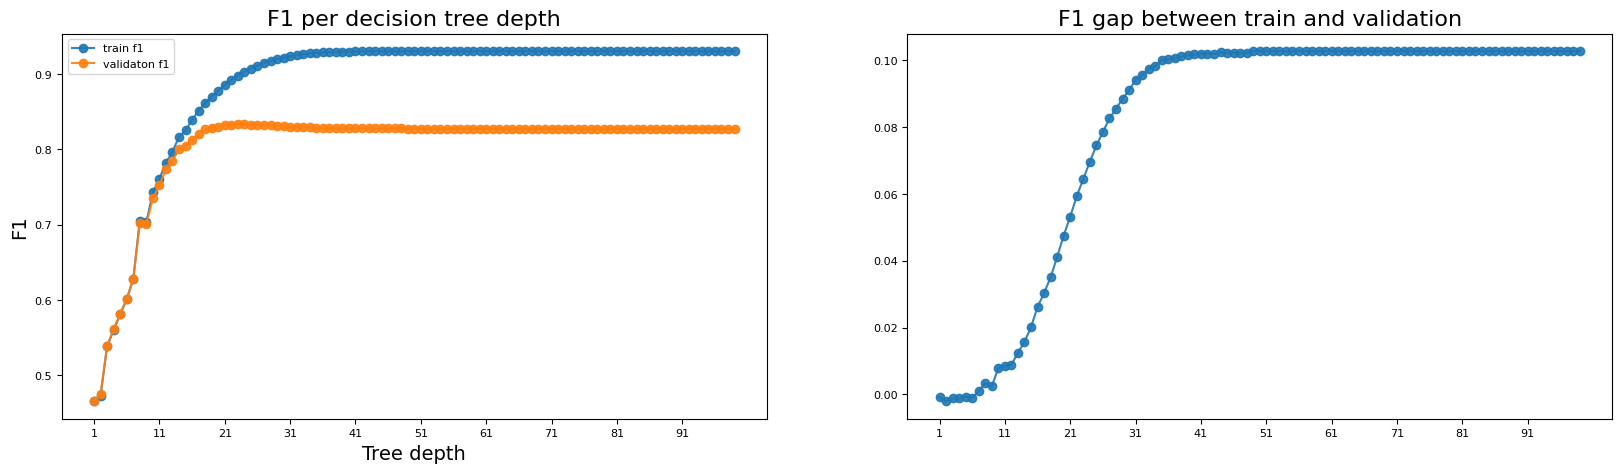

In [73]:
# # # fitting trees of depth 1 to 24
depths = range(1,100)
models = [DecisionTreeClassifier(max_depth=d, class_weight=class_weight, random_state=seed) for d in depths]

train_scores, val_scores, err_f1 = model_tuner(models, x_train, y_train, x_val, y_val, fbeta_score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(depths, train_scores, '-o', label='train f1', alpha=0.9)
ax1.plot(depths, val_scores, '-o', label='validaton f1', alpha=0.9)
ax1.set_title('F1 per decision tree depth', fontsize=16)
ax1.set_xlabel('Tree depth', fontsize=14)
ax1.set_ylabel('F1', fontsize=14)
ax1.set_xticks(range(1, 100, 10))

ax2.plot(depths, err_f1, '-o', alpha=0.9)
ax2.set_title('F1 gap between train and validation', fontsize=16)
ax2.set_xticks(range(1, 100, 10))
ax1.legend()
plt.show()

Looking the above graph we saw an interesting pattern, the validation f1 score increase till reached a value near 20 and after it start to decrease. This highlights that the model start to overfit. The error graph shows near those values we have a relatively small difference between the train and validation score, while with a bigger values it increases. Therefore, we chose ha maximum depth that values that maximize the validation score.

F1:		train=0.892, validation=0.833
Recall:		train=0.983, validation=0.916
Precision:	train=0.739, validation=0.692


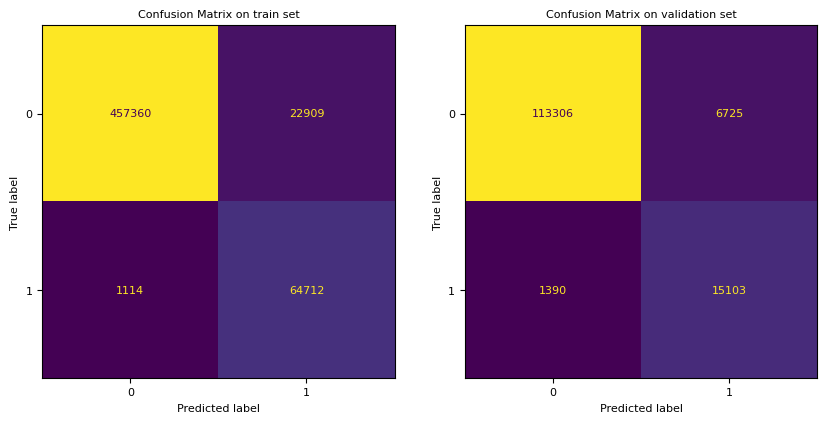

In [83]:
depths = min(depths) + np.argmax(val_scores)

dt_bin_tuned = DecisionTreeClassifier(max_depth=depths,
                                      class_weight=class_weight,
                                      random_state = seed)
dt_bin_tuned = dt_bin_tuned.fit(x_train, y_train)
evaluate_model(dt_bin_tuned, x_train, y_train, x_val, y_val)

A slight increased of the performance. The classifier tends to predict more times fail rather than completed, but this could be acceptable. If there is uncertanty, it's better, both for economic and computational reason, to not execute a job which has any chance of fails. It's all about a tradeoff between reliability of the model and resources allocations.

#### Random Forest


In the field of machine learning, **ensemble methods** are used to combine base estimators (i.e. weak learners). Two types of ensemble methods are averaging (eg. bagging) and boosting (eg. gradient boosting). Ensemble methods not only increase the performance but also reduce the risk of overfitting. We start using the bagging one, expecially the **Random Forest**.

It consists of a large number of individual Decision Trees, where at the end the predictions of the learners are aggregated. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction.

Training time: 0.0 seconds
F1:		train=0.923, validation=0.841
Recall:		train=0.980, validation=0.888
Precision:	train=0.815, validation=0.752


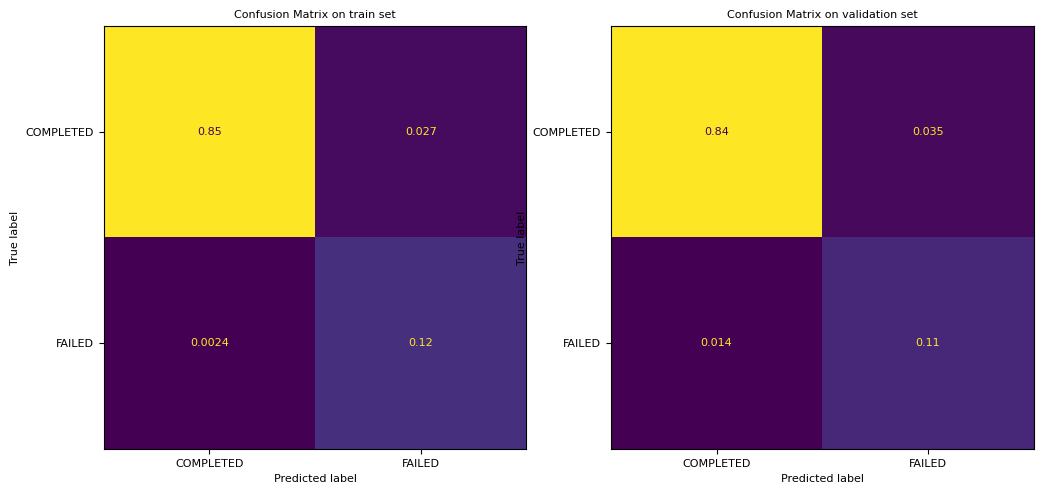

In [9]:
rf_bin = RandomForestClassifier(class_weight=class_weight, random_state=seed, n_jobs=-1)
start_time = time.time()
rf_bin.fit(x_train, y_train)
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.1f} seconds")
evaluate_model(rf_bin, x_train, y_train, x_val, y_val)

As we expected, we obtain sligthy better results compared to classi Decision Trees. Again, looking the gap between the train and the validation performances, we can notice the presence of overfiting. So, we try to reduce it with tuning.

Random Forest is a set of Decision Trees, hence we have to tune the number of estimators used

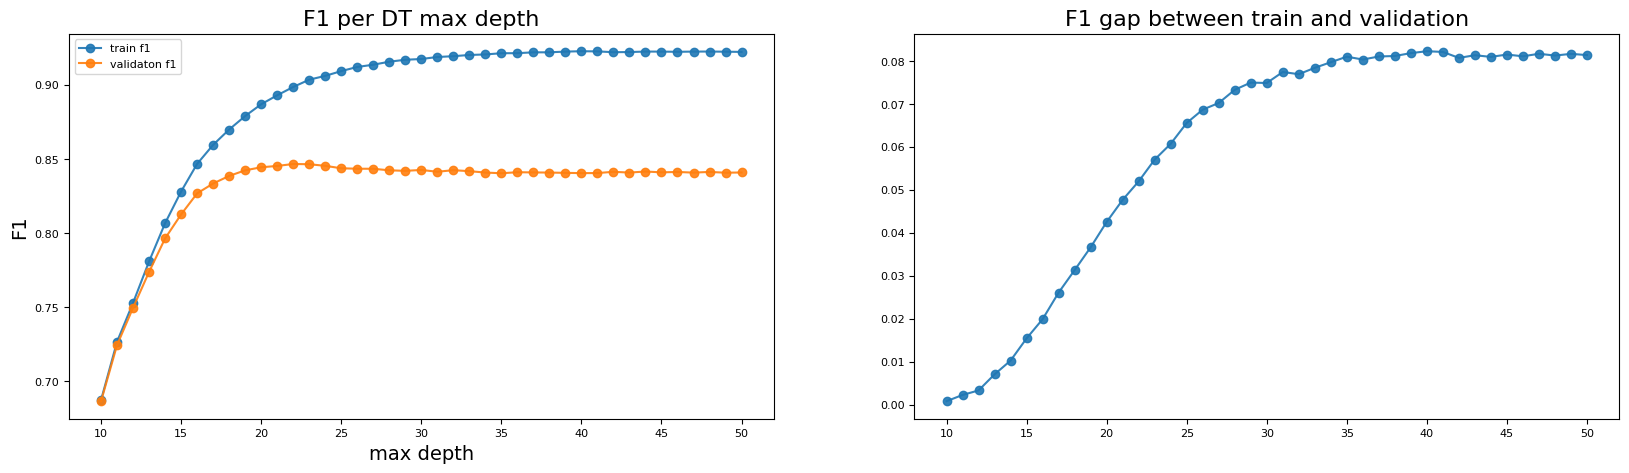

In [11]:
estimators =  range(100,200)
models = [RandomForestClassifier(n_estimators=n, class_weight=class_weight, random_state=seed, n_jobs=-1) for n in estimators]

train_scores, val_scores, err_f1 = model_tuner(models, x_train, y_train, x_val, y_val, fbeta_score)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(estimators, train_scores, '-o', label='train f1', alpha=0.9)
ax1.plot(estimators, val_scores, '-o', label='validaton f1', alpha=0.9)
ax1.set_title('F1 per number of estimators', fontsize=16)
ax1.set_xlabel('n° estimators', fontsize=14)
ax1.set_ylabel('F1', fontsize=14)
ax1.set_xticks(range(min(estimators), max(estimators)+1, 5))

ax2.plot(estimators, err_f1, '-o', alpha=0.9)
ax2.set_title('F1 gap between train and validation', fontsize=16)
ax2.set_xticks(range(min(estimators), max(estimators)+1, 5))
ax1.set_xlabel('n° estimators', fontsize=14)
ax1.set_ylabel('F1 difference', fontsize=14)
ax1.legend()
plt.show()

Same behavior like the standard Decision Tree. As always chose as max depth that value that maximize the validation score. 

Max depth: 22
Training time: 14.2 seconds
F1:		train=0.923, validation=0.841
Recall:		train=0.980, validation=0.888
Precision:	train=0.815, validation=0.752


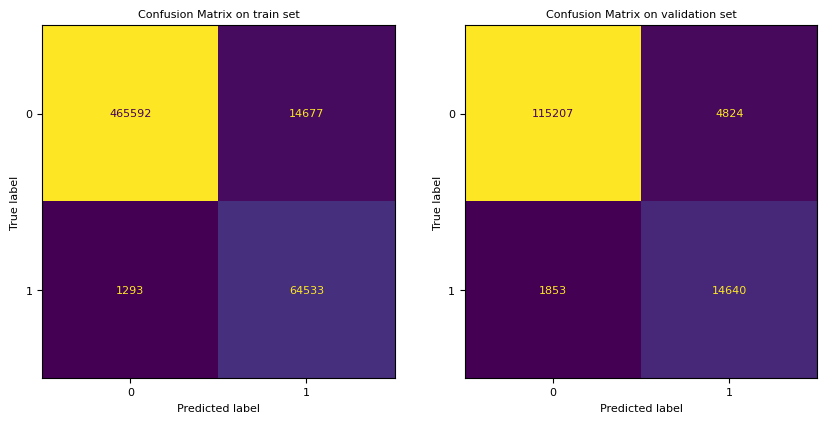

In [26]:
max_depth_rf = min(depths) + np.argmax(val_scores)
print(f"Max depth: {max_depth_rf}")

rf_bin_tuned = RandomForestClassifier(max_depth=max_depth_rf,
                                      class_weight=class_weight,
                                      random_state=seed,
                                      n_jobs=-1)
start_time = time.time()
rf_bin_tuned.fit(x_train, y_train)
rf_train_time = time.time() - start_time
print(f"Training time: {rf_train_time:.1f} seconds")
evaluate_model(rf_bin, x_train, y_train, x_val, y_val)

#### Gradient Boosting


The last algorithm class tested is the **Gradient Booosting**. In particulare we use the **XGBoost**, that is a open-source implementation of the gradient boosted trees algorithm. It is so called for the uses of Decision Trees as weak classifiers and the gradient descent as loss function optimizer.

F1:		train=0.758, validation=0.742
Recall:		train=0.717, validation=0.701
Precision:	train=0.869, validation=0.854


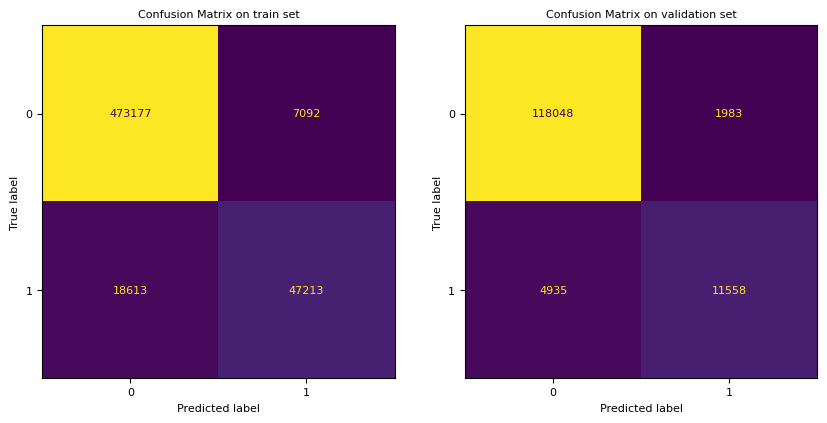

In [9]:
xgb_bin = XGBClassifier(objective='binary:logistic',
                        booster='gbtree',
                        random_state=seed,
                        n_jobs = -1,
)
xgb_bin.fit(x_train, y_train)
evaluate_model(xgb_bin, x_train, y_train, x_val, y_val)

The performances are lower w.r.t. those of Random Forest. Surprisingly, this model not suffer of overfitting. Indeed, the difference of score between train and validation is very little in all the 3 metrics.

Tuning a bit the hyper-parameters trying to improve pefromances.

In [16]:
xgb_parameters = {
    'max_depth': np.arange(3, 101, dtype=np.int16),
    'min_child_weight': np.arange(1, 11, dtype=np.int16),
    'colsample_bytree' :np.arange(1, 11, dtype=np.int16),
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'scale_pos_weight': class_weight[1],
    'random_state': seed,
    'n_jobs': -1,
    'learning_rate': 0.1
}

clf_tuner = GridSearchCV(XGBClassifier(), xgb_parameters)


print("Best param XGBoost (binary):")
print(clf_tuner.best_params_)

Best param XGBoost (binary):
{'max_depth': 86, 'min_child_weight': 7, 'colsample_bytree': 1, 'objective': 'binary:logistic', 'booster': 'gbtree', 'scale_pos_weight': 4.148019019840185, 'random_state': 42, 'n_jobs': -1, 'learning_rate': 0.1}


F1:		train=0.872, validation=0.833
Recall:		train=0.958, validation=0.913
Precision:	train=0.725, validation=0.695


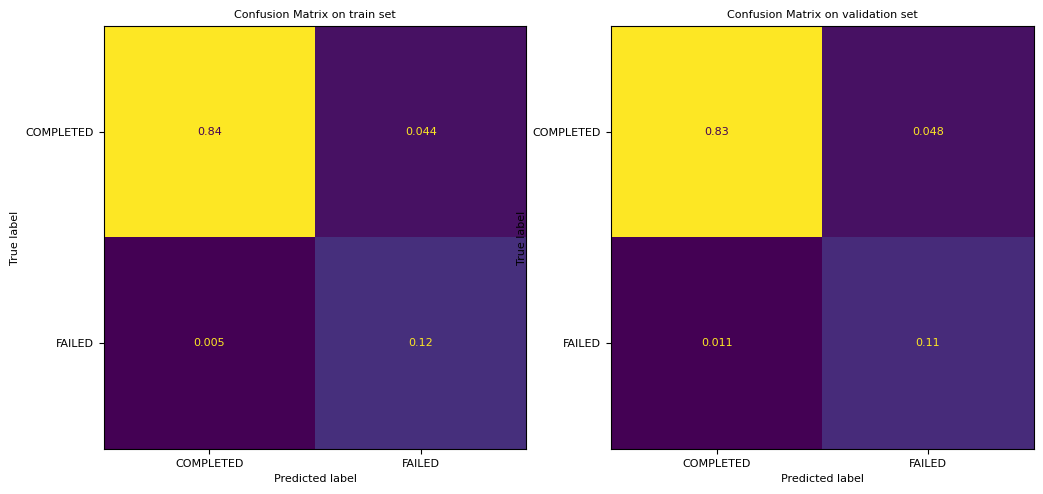

In [18]:
xgb_bin_tuned = XGBClassifier(**clf_tuner.best_params_)
xgb_bin_tuned.fit(x_train, y_train)
evaluate_model(xgb_bin_tuned, x_train, y_train, x_val, y_val)

The tuning lead the model to a comparable performances in terms of F1,Precision and Recall with the previous. Again, there is overfiting of train data and looking the score of Precision we can say that it tends to predict more time Failed when uncerntanty. 

#### Stacking Classifiers

Stacking, is an ensemble learning technique that combines multiple base models to improve overall predictive performance. The basic idea behind stacking is to train a meta-model, to make predictions based on the outputs of several base models. Each base model is trained on a subset of the data and validated on a different subset. Finmally, the meta-model, is trained using the predictions from the base models as input features. This meta-model learns to combine the base model predictions to make the final prediction.

Stacking can be more powerful than individual models because it leverages the strengths of different models and tries to compensate for their weaknesses. It is essential to choose diverse base models to ensure that the ensemble benefits from the different perspectives of each model.

In light of this, we try to combine our 2 best models Random Forest and XGB trying to improve the results

F1:		train=0.917, validation=0.832
Recall:		train=0.934, validation=0.838
Precision:	train=0.881, validation=0.819


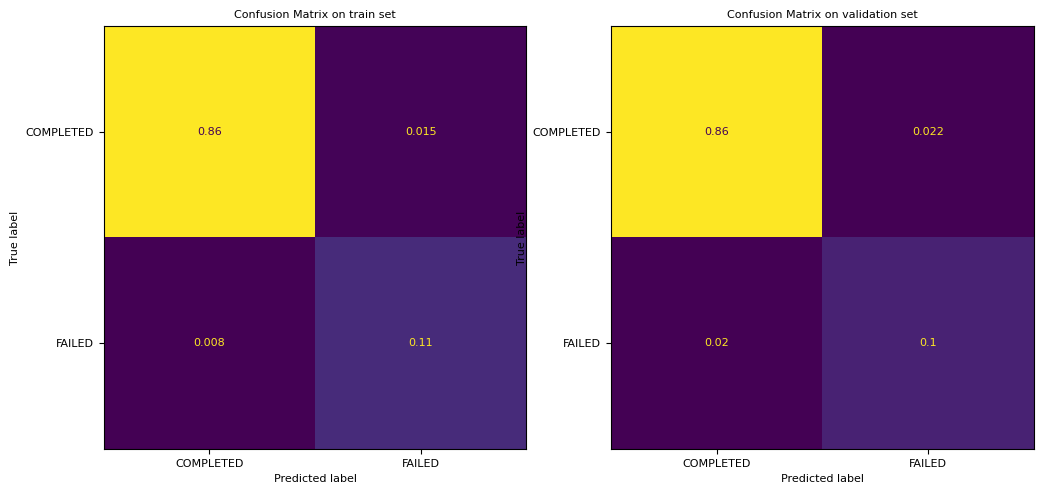

In [13]:
models = [
    ('rf', RandomForestClassifier(class_weight=class_weight, random_state=seed, n_jobs=-1)),
    ('xgb', XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=seed, n_jobs=-1, max_depth=86, min_child_weight=7.0, scale_pos_weight=class_weight[1]))
]
clf = StackingClassifier(estimators = models, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(x_train, y_train)
evaluate_model(clf, x_train, y_train, x_val, y_val)

Remarkably, these stacking shows effective results by improving the results. The final model have an F1 score very very similar to those of the base models, while show a smaller gap between Recall and Precision. This means that the model have a better comprehension of data and understand better when a jobs is likely to fails or not. 

Overall, it's more balanced, but it require more time to be trained.

#### Neural Networks

Last approach, just for comparison with machine learning algorithms, is through the Neural Network. We don't belive that they are effective with this unbalanced dataset. However, it's important to mention them and compare their results.

In [7]:
nn_model_bin = build_cnn_model((x_train.shape[1],1,), 1, 3, 2)
nn_model_bin.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 16, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 256)            98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 256)            196864    
                                                             

2023-11-08 12:25:43.621135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9910 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
nn_model_bin.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     loss_weights=list(class_weight.values()),
                     metrics=tf.keras.metrics.BinaryAccuracy())
history = nn_model_bin.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), validation_batch_size=1024, callbacks=[callback])
nn_model_bin.save_weights('checkpoints/nn_bin.h5')

Epoch 1/100


2023-11-08 12:25:47.856135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8901
2023-11-08 12:25:49.597793: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f21d017dc00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-08 12:25:49.597817: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-11-08 12:25:49.602528: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-08 12:25:49.701571: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1067/1067 [==============================] - 18s 12ms/step - loss: 0.3454 - binary_accuracy: 0.8800 - val_loss: 0.3041 - val_binary_accuracy: 0.8846
Epoch 2/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2751 - binary_accuracy: 0.8903 - val_loss: 0.2654 - val_binary_accuracy: 0.8926
Epoch 3/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2539 - binary_accuracy: 0.8958 - val_loss: 0.2427 - val_binary_accuracy: 0.8986
Epoch 4/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2422 - binary_accuracy: 0.8999 - val_loss: 0.2331 - val_binary_accuracy: 0.9022
Epoch 5/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2339 - binary_accuracy: 0.9037 - val_loss: 0.2272 - val_binary_accuracy: 0.9074
Epoch 6/100
1067/1067 [==============================] - 13s 12ms/step - loss: 0.2279 - binary_accuracy: 0.9060 - val_loss: 0.2270 - val_binary_accuracy: 0.9047
Epoch 7/100
1067/1067 [=======================

In [9]:
pred_train = nn_model_bin.predict(x_train, batch_size=512)
pred_val = nn_model_bin.predict(x_val, batch_size=512)
pred_train = pred_train.reshape(pred_train.shape[0])
pred_val = pred_val.reshape(pred_val.shape[0])
pred_train = np.where(pred_train >= 0.5, 1, 0)
pred_val = np.where(pred_val >= 0.5, 1, 0)

267/267 [==============================] - 1s 3ms/step


F1:
 - train set:		0.662
 - validation set:	0.651
Recall:
 - train set:		0.621
 - validation set:	0.609
Precision:
 - train set:		0.780
 - validation set:	0.770


<function matplotlib.pyplot.show(close=None, block=None)>

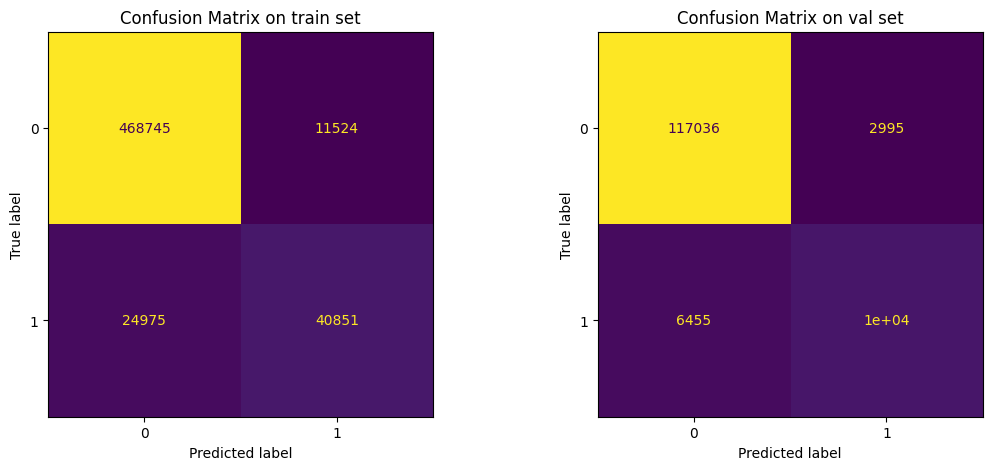

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support

t_precision, t_recall, t_f1, _ = precision_recall_fscore_support(y_train, pred_train, beta=1.5, average="binary")
v_precision, v_recall, v_f1, _ = precision_recall_fscore_support(y_val, pred_val, beta=1.5, average="binary")
print(f"F1:\n - train set:\t\t{t_f1:.3f}\n - validation set:\t{v_f1:.3f}")
print(f"Recall:\n - train set:\t\t{t_recall:.3f}\n - validation set:\t{v_recall:.3f}")
print(f"Precision:\n - train set:\t\t{t_precision:.3f}\n - validation set:\t{v_precision:.3f}")

train_cm = confusion_matrix(y_train, pred_train)
val_cm = confusion_matrix(y_val, pred_val)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=val_cm).plot(ax=ax2,  colorbar=False)
ax1.set_title("Confusion Matrix on train set")
ax2.set_title("Confusion Matrix on val set")
plt.show

As we expected, the performances of the NNs are not effective and obtain a very very low results. The high number of featuers and the complexity of the task doesn't help the network in abstracting the data. However, it's important to notice that, in contrapposition to the behavior of ML models, they predict more likely a complete exit state when uncertanty.

## Multiclass

As desribed before, the possible exit states are: **COMPLETED**, **FAIL**, **OUT OF MEMORY** and **TIMEOUT**, so we extend our work to the multiclass case. In general, performances in binary classifications are way better compared than multiclass one. Hence, we use only best models, by replicating Random Forest and the XGBoost because are the two most promising.

In [3]:
print("Loading data... ", end="")
data, labels = get_data("data/job_table_preproc.pkl")
print("Lodaded!")
print("Labels:", np.unique(labels))

Loading data... Lodaded!
Labels: ['COMPLETED' 'FAILED' 'OUT_OF_MEMORY' 'TIMEOUT']


Again, encode classes into integer values

In [4]:
lab_enc_mc = LabelEncoder()
print(f"Old values: {labels[:5]}")
labels = lab_enc_mc.fit_transform(labels)
print(f"Old values: {labels[:5]}")

Old values: ['COMPLETED' 'COMPLETED' 'COMPLETED' 'FAILED' 'COMPLETED']
Old values: [0 0 0 1 0]


Split the data into train, validation and test sets and normalize using only train information

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=0.7, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_val = (x_val - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

print(f"train data shape: {x_train.shape}")
print(f"val data shape: {x_val.shape}")
print(f"test data shape: {x_test.shape}")
print(f"train labels shape: {len(y_train)}")
print(f"val labels shape: {len(y_val)}")
print(f"test labels shape: {len(y_test)}")

train data shape: (546095, 16)
val data shape: (136524, 16)
test data shape: (292551, 16)
train labels shape: 546095
val labels shape: 136524
test labels shape: 292551


Print the distribution of the classes among the splits

In [7]:
train_dist = dict(Counter(y_train))
val_dist = dict(Counter(y_val))
test_dist = dict(Counter(y_test))

for i,cls in enumerate(lab_enc_mc.classes_):
    print(f'Class: {cls}')
    print(f" - train:\t{train_dist[i]/len(y_train):.3f}")
    print(f" - val:\t\t{val_dist[i]/len(y_val):.3f}")
    print(f" - test:\t{test_dist[i]/len(y_test):.3f}")

Class: COMPLETED
 - train:	0.879
 - val:		0.879
 - test:	0.881
Class: FAILED
 - train:	0.102
 - val:		0.102
 - test:	0.101
Class: OUT_OF_MEMORY
 - train:	0.004
 - val:		0.004
 - test:	0.004
Class: TIMEOUT
 - train:	0.014
 - val:		0.015
 - test:	0.014


As you can see, classere are heavily unbalanced. However, their distribution have been preserved with the split. 

Let's assign to each class a weight proportional to the inverse of its frequence in the train split

In [6]:
class_weight_mc = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_mc = {k:v for k,v in enumerate(class_weight_mc)}
class_weight_mc

{0: 0.28426517222639813,
 1: 2.4521113226524895,
 2: 58.16947166595654,
 3: 17.49631551967192}

### Random Forest

F1:		train=0.843, validation=0.743
Recall:		train=0.968, validation=0.841
Precision:	train=0.767, validation=0.687


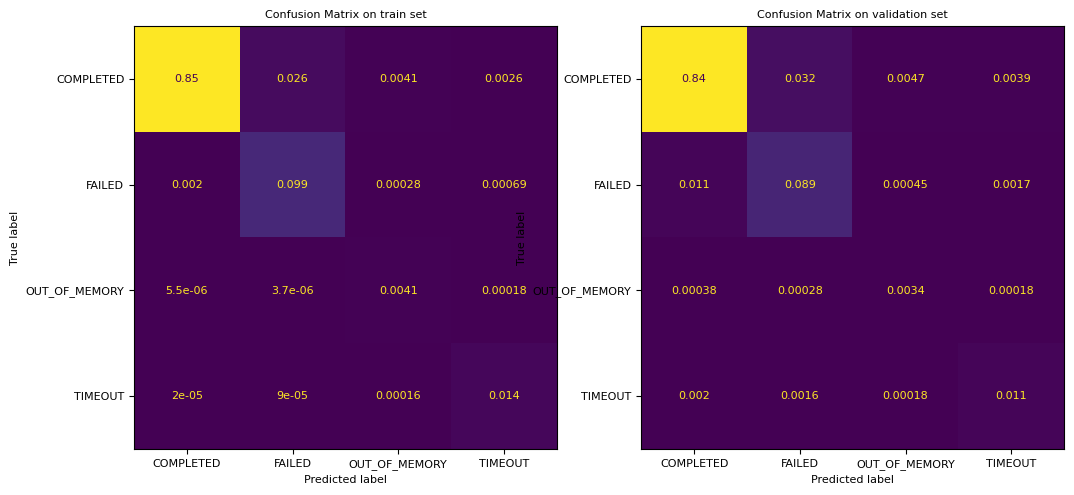

In [56]:
rf_mc_clf = RandomForestClassifier(class_weight=class_weight_mc, random_state=seed, n_jobs=-1)
rf_mc_clf.fit(x_train, y_train)
evaluate_model(rf_mc_clf, x_train, y_train, x_val, y_val, average="macro")

As we expected, these scores are lower the ones obtaines with the binary task. The confusion matrix is not enough when we dealing with multiclass. Indeed, by it we can only say that the majority of the prediction are between Completed and Failed (that there are classes more present). 

Let's print the clasification report to compare F1 score of each class


In [26]:
train_pred = rf_mc_clf.predict(x_train)
val_pred = rf_mc_clf.predict(x_val)

print('*'*90+' Train set '+'*'*90)
print(classification_report(y_train, train_pred, target_names=lab_enc_mc.classes_))
print('*'*90+' Validation set '+'*'*90)
print(classification_report(y_val, val_pred, target_names=lab_enc_mc.classes_))

****************************************************************************************** Train set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       1.00      0.96      0.98    480269
       FAILED       0.79      0.97      0.87     55676
OUT_OF_MEMORY       0.48      0.96      0.64      2347
      TIMEOUT       0.80      0.98      0.88      7803

     accuracy                           0.96    546095
    macro avg       0.77      0.97      0.84    546095
 weighted avg       0.97      0.96      0.97    546095

****************************************************************************************** Validation set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.98      0.95      0.97    120031
       FAILED       0.72      0.87      0.79     13933
OU

As you can see, both on train and validation the model struggle in classify correctly the OUT_OF_MEMORY exit state where it achieve only 64% of f1 on train and 52% on validation. Anyway, considering that the class have less than 1% of presence inside the data it is acceptable. It is possible that tuning more the weights of classes, we can achieve higher score, but we should scacrifice points elsewhere. However, the model have a discrete ability in correctly predicting FAILED and TIMEOUT classes.

Also in this case, we can see that the big gap between train and validation performances highlight the presence of overfitting.

### XGBoost

F1:		train=0.787, validation=0.766
Recall:		train=0.732, validation=0.710
Precision:	train=0.860, validation=0.842


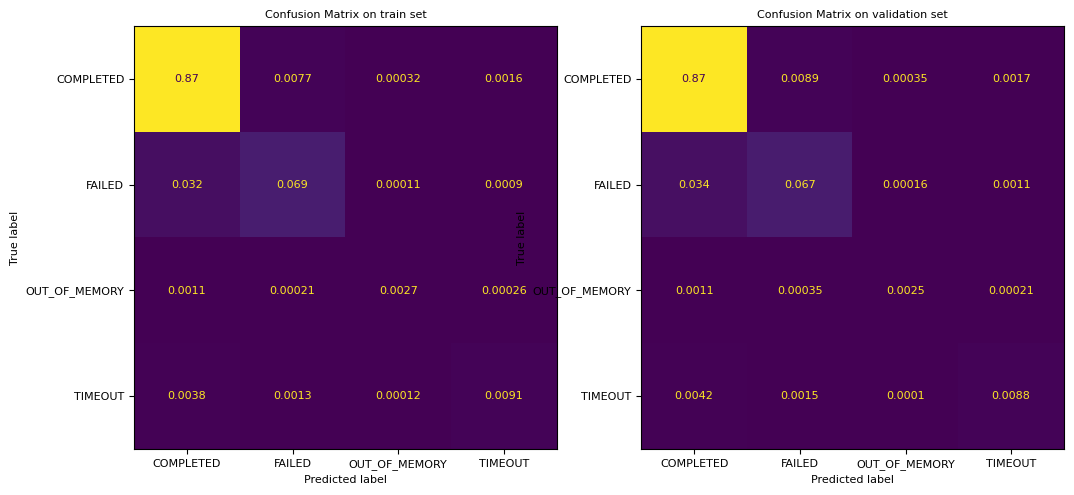

****************************************************************************************** Train set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.96      0.99      0.97    480269
       FAILED       0.88      0.67      0.76     55676
OUT_OF_MEMORY       0.83      0.63      0.72      2347
      TIMEOUT       0.77      0.63      0.69      7803

     accuracy                           0.95    546095
    macro avg       0.86      0.73      0.79    546095
 weighted avg       0.95      0.95      0.95    546095

****************************************************************************************** Validation set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.96      0.99      0.97    120031
       FAILED       0.86      0.65      0.74     13933
OU

In [27]:
xgb_mc = XGBClassifier(objective='multi:softmax',
                        booster='gbtree',
                        random_state=seed,
                        n_jobs = -1,
)
xgb_mc.fit(x_train, y_train)
evaluate_model(xgb_mc, x_train, y_train, x_val, y_val, average="macro")

train_pred = xgb_mc.predict(x_train)
val_pred = xgb_mc.predict(x_val)

print('*'*90+' Train set '+'*'*90)
print(classification_report(y_train, train_pred, target_names=lab_enc_mc.classes_))
print('*'*90+' Validation set '+'*'*90)
print(classification_report(y_val, val_pred, target_names=lab_enc_mc.classes_))

The XGBoost is more able than the Random forest model in classify correct the OUT_OF_MEMORY class and in general it achieve a slightly better scores. Of course, it lost some percentage points on other classes, indication that the class weights just move errore between classes depending on the model used. However, it is important to note that it not overfits and excpet for the COMPLETED class, the others are quite the same probability to be predicted good.

In [35]:
xgb_parameters = {
    'max_depth': np.arange(3, 101, dtype=np.int16),
    'min_child_weight': np.arange(1, 11, dtype=np.int16),
    'colsample_bytree': np.arange(1, 11, dtype=np.int16),
    'objective': 'multi:softmax',
    'booster': 'gbtree',
    'random_state': seed,
    'n_jobs': -1,
    'learning_rate': 0.1
}

clf_tuner = GridSearchCV(XGBClassifier(), xgb_parameters)

print("Best param XGBoost (multiclass):")
print(clf_tuner.best_params_)

Best param XGBoost (multiclass):
{'max_depth': 86, 'min_child_weight': 7, 'objective': 'multi:softmax', 'booster': 'gbtree', 'scale_pos_weight': 4.148019019840185, 'random_state': 42, 'n_jobs': -1, 'learning_rate': 0.1}


F1:		train=0.848, validation=0.795
Recall:		train=0.819, validation=0.762
Precision:	train=0.881, validation=0.833


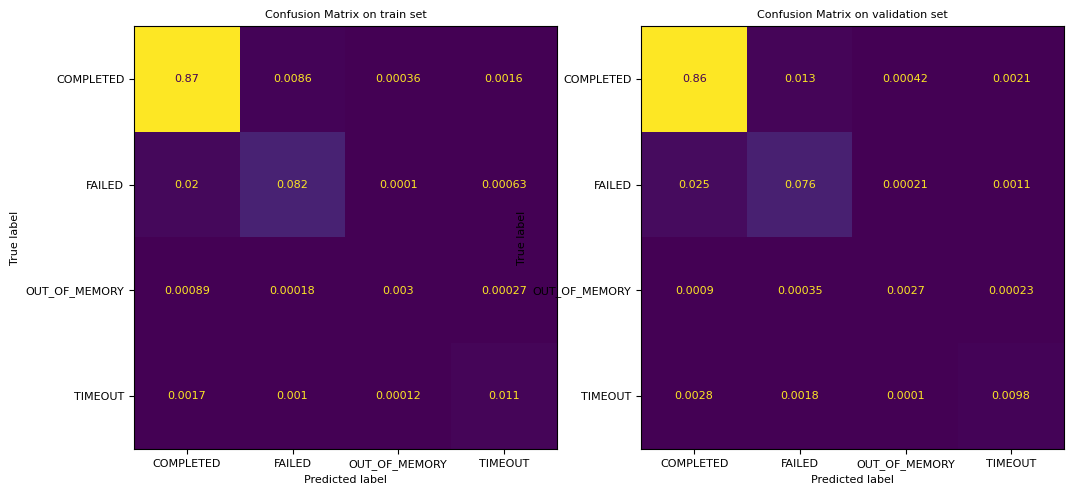

****************************************************************************************** Train set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.98      0.99      0.98    480269
       FAILED       0.89      0.80      0.84     55676
OUT_OF_MEMORY       0.83      0.69      0.75      2347
      TIMEOUT       0.82      0.80      0.81      7803

     accuracy                           0.96    546095
    macro avg       0.88      0.82      0.85    546095
 weighted avg       0.96      0.96      0.96    546095

****************************************************************************************** Validation set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.97      0.98      0.98    120031
       FAILED       0.84      0.74      0.79     13933
OU

In [37]:
xgb_mc = XGBClassifier(**xgb_parameters)
xgb_mc.fit(x_train, y_train)
evaluate_model(xgb_mc, x_train, y_train, x_val, y_val, average="macro")

train_pred = xgb_mc.predict(x_train)
val_pred = xgb_mc.predict(x_val)

print('*'*90+' Train set '+'*'*90)
print(classification_report(y_train, train_pred, target_names=lab_enc_mc.classes_))
print('*'*90+' Validation set '+'*'*90)
print(classification_report(y_val, val_pred, target_names=lab_enc_mc.classes_))

After the tuning, we can notice a little increase of the performace. The F1 score increase for all the classes, so the model perform better, but it tends to overfits more.

 In conlcusion we can say that gradient boosting method are very efficient also in multiclass classification. It achieve result close to those of the binary task and with a precise tuning it problably can reach the binary performances.

### Multiple binary classifiers

In order to enhance the performance in the multiclass case, we can split the prediction task on differnt model. Each model is specialized on a specific class and it produce a binary classification on it (belong to this class or not). So each sample is then passed in parallel to 4 different model and at the end the vector of model's prediction is than computed by a final discriminant model to obtain the final prediction.

<center><img src="/home/matteo/github/job_exit_state/res/multiple_clfs.png" align="center"/></center>

Start by create the labels for our big model. Model at level 0 are trained with a surrogated version of the labels. This inner labels are a sort of binarization of the final labels where we have a 1 if the model belog to the model target class and 0 otherwise.

In [7]:
train_labels = []
for lbl in range(4):
    train_labels.append([int(y_train[i] == lbl) for i in range(len(y_train))])
train_labels.append(y_train)

print('Number of labels arrays:', len(train_labels))
print('Number of items inside each array:', len(train_labels[0]))

Number of labels arrays: 5
Number of items inside each array: 546095


Compute the new model class weight. The class weight varying based on the *base classifier*. For the first (i.e., that must classify if a job is completed or not) are set to 1 becuse the dataset is unbalnced towards the positive class (i.e., the completed job)

In [8]:
weights = [
    {k:v for k,v in enumerate(compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=train_labels[i]))} for i in range(4)
]
weights[0] = {0:1, 1:1}
weights

[{0: 1, 1: 1},
 {0: 0.5567637061369971, 1: 4.904222645304979},
 {0: 0.5021581688576325, 1: 116.33894333191309},
 {0: 0.5072479249180742, 1: 34.99263103934384}]

Now, create the model and train it

In [14]:
mbc = MultiBinaryClassifier(weights, seed=seed)
mbc.fit(x_train, train_labels)

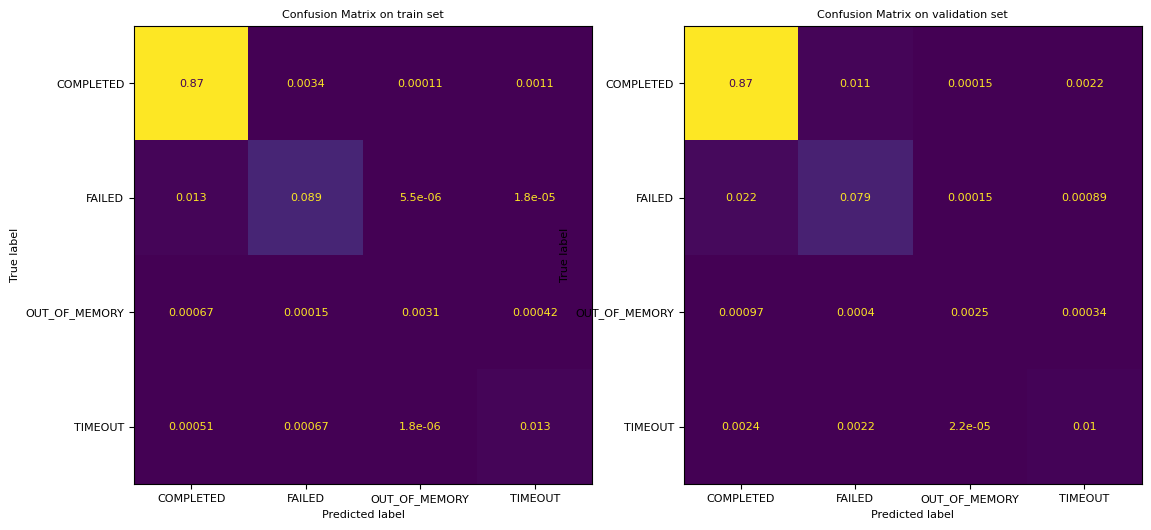

****************************************************************************************** Train set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.98      0.99      0.99    480269
       FAILED       0.96      0.87      0.91     55676
OUT_OF_MEMORY       0.96      0.71      0.82      2347
      TIMEOUT       0.89      0.92      0.90      7803

     accuracy                           0.98    546095
    macro avg       0.95      0.87      0.91    546095
 weighted avg       0.98      0.98      0.98    546095

****************************************************************************************** Validation set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.97      0.98      0.98    120031
       FAILED       0.85      0.78      0.81     13933
OU

In [15]:
train_preds = mbc.predict(x_train)
val_preds = mbc.predict(x_val)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
print_confusion_matrix(y_train, train_preds, 'multiclass', ax1)
ax1.set_title("Confusion Matrix on train set")
print_confusion_matrix(y_val, val_preds, 'multiclass', ax2)
ax2.set_title("Confusion Matrix on validation set")
plt.show()

print('*'*90+' Train set '+'*'*90)
print(classification_report(y_train, train_preds, target_names=lab_enc_mc.classes_))
print('*'*90+' Validation set '+'*'*90)
print(classification_report(y_val, val_preds, target_names=lab_enc_mc.classes_))

# Test best models 

We evaluate on the test set only the 2 best model for both binary and multiclass task. For the first task, we select the stacking of Random Forest and XGBoost for its high similarity of Precision and Recall. For the second, we choose the MultiBinary model because, even if the difference is very small compared to the others, it have the best performances

In [2]:
df = pd.read_pickle('/home/matteo/github/job_exit_state/data/job_table_preproc.pkl')
labels = df.pop('job_state')

x_train, x_test, y_train_mc, y_test_mc = train_test_split(df.to_numpy(), labels.to_numpy(), test_size=0.3, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

<h3>Binary</h3>

In [25]:
y_train_bin = [int(lbl == 'FAILED') for lbl in y_train_mc]
y_test_bin = [int(lbl == 'FAILED') for lbl in y_test_mc]

weight_bin = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_bin), y=y_train_bin)
weight_bin = {k:v for k,v in enumerate(weight_bin)}

              precision    recall  f1-score   support

   COMPLETED       0.98      0.98      0.98    263055
      FAILED       0.81      0.83      0.82     29496

    accuracy                           0.96    292551
   macro avg       0.89      0.91      0.90    292551
weighted avg       0.96      0.96      0.96    292551



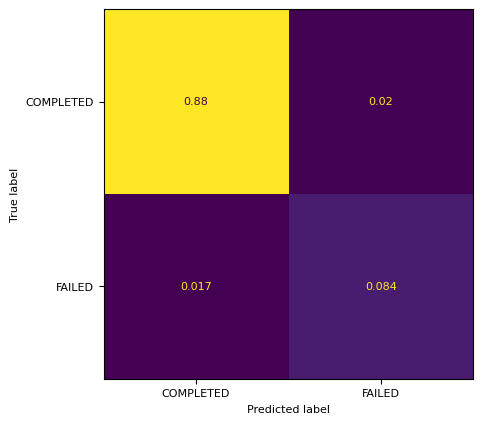

In [26]:
models = [
    ('rf', RandomForestClassifier(class_weight=weight_bin, random_state=seed, n_jobs=-1)),
    ('xgb', XGBClassifier(objective='binary:logistic', booster='gbtree', random_state=seed, n_jobs=-1, max_depth=86, min_child_weight=7.0, scale_pos_weight=weight_bin[1]))
]
clf = StackingClassifier(estimators = models, final_estimator=LogisticRegression(), n_jobs=-1)
clf.fit(x_train, y_train_bin)

pred = clf.predict(x_test)
cm = confusion_matrix(y_test_bin, pred, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=['COMPLETED', 'FAILED']).plot(colorbar=False)
print(classification_report(y_test_bin, pred, target_names=['COMPLETED', 'FAILED']))
plt.show()

<h3>Multi-class</h3>

In [3]:
label_enc_mc = LabelEncoder()
y_train_mc = label_enc_mc.fit_transform(y_train_mc)
y_test_mc = label_enc_mc.transform(y_test_mc)

train_labels_mc = []
for lbl in range(4):
    train_labels_mc.append([int(y_train_mc[i] == lbl) for i in range(len(y_train_mc))])
train_labels_mc.append(y_train_mc)

weights_mc = [
    {k:v for k,v in enumerate(compute_class_weight(class_weight="balanced", classes=np.array([0,1]), y=train_labels_mc[i]))} for i in range(4)
]
weights_mc[0] = {0:1, 1:1}

               precision    recall  f1-score   support

    COMPLETED       0.97      0.99      0.98    257683
       FAILED       0.86      0.79      0.82     29496
OUT_OF_MEMORY       0.83      0.57      0.67      1248
      TIMEOUT       0.73      0.68      0.70      4124

     accuracy                           0.96    292551
    macro avg       0.85      0.75      0.79    292551
 weighted avg       0.96      0.96      0.96    292551



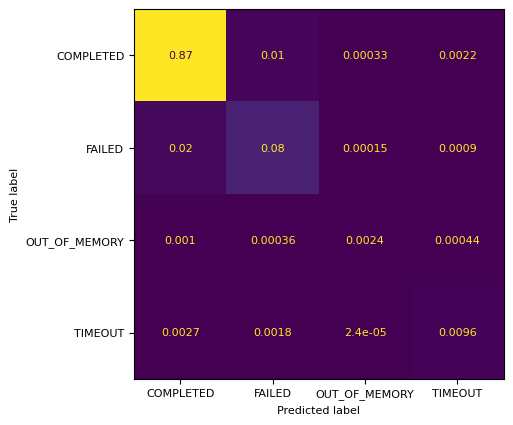

In [11]:
mbc = MultiBinaryClassifier(weights_mc, seed=seed)
mbc.fit(x_train, train_labels_mc)

pred = mbc.predict(x_test)
cm = confusion_matrix(y_test_mc, pred, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm ,display_labels=label_enc_mc.classes_).plot(colorbar=False)
print(classification_report(y_test_mc, pred, target_names=label_enc_mc.classes_))

# Results analysis 

This sub-section aims to execute an interesting work concerning the visualisation of the original dataset, the projected dataset via lda and the investigation of the characteristics of well-divided data and conflict zones.

In [3]:
df = pd.read_pickle('/home/matteo/github/job_exit_state/data/job_table_preproc.pkl')
labels = df.pop('job_state')

### Visualization of original dataset and Inspection of characteristics

Selection of a conflict area (red rect) and a well divisible one (green)

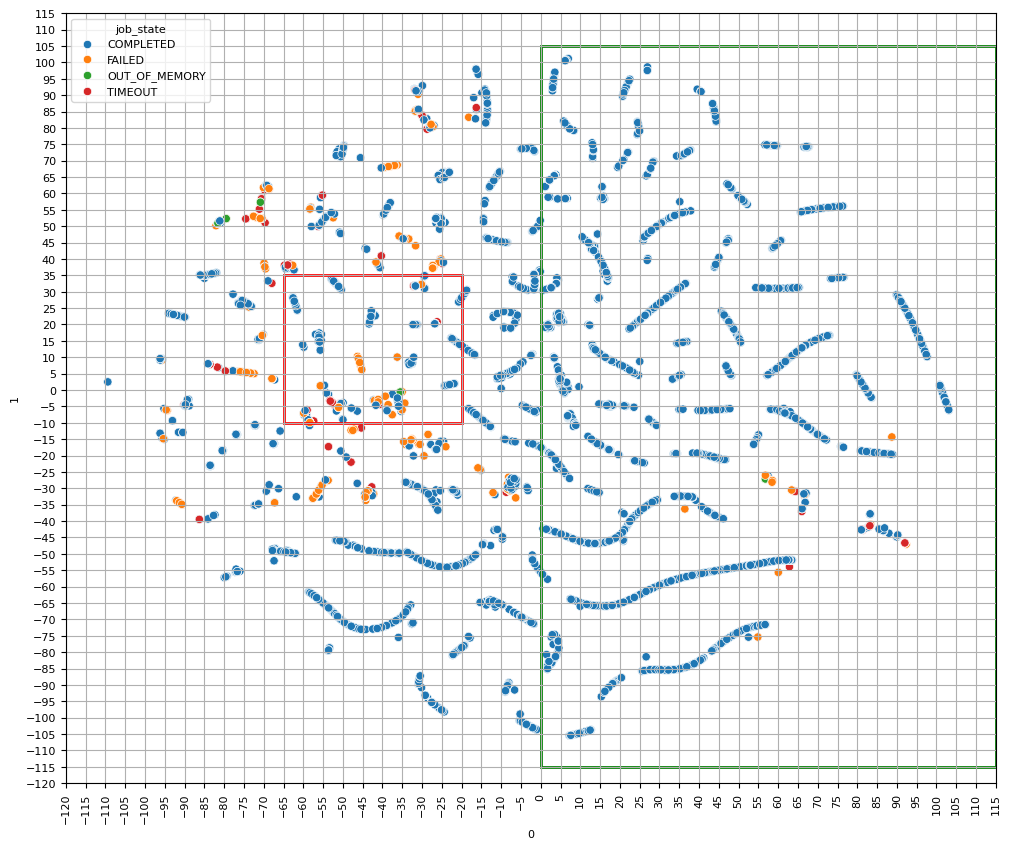

In [10]:
df_train, df_test, labels_train, labels_test = train_test_split(df, labels, train_size=0.7, random_state=seed)

x_coord_conflict_area = [-65, -20]
y_coord_conflict_area = [-10, 35]

x_coord_good = [0, 115]
y_coord_good = [-115, 105]

tsne_df_original = show_space(df_train[:10000], labels_train[:10000], 2, x_coord_conflict_area, y_coord_conflict_area, x_coord_good, y_coord_good)

In [11]:
tsne_df_original = pd.concat([tsne_df_original[0:10000], labels_train[0:10000]], axis=1)

For both rects we take only completed jobs, in order to be comparable and to find some substantial difference which could be corrected when someone give a job to slurm.
Is there any constraint I can force to make the completed jobs more similar? Is it possible that some jobs are close to failed because an uninformed user only sets a few parameters? Maybe by putting in a few more simple pieces of information these jobs would be classified correctly.

In [ ]:
completed_index = list(tsne_df_original[tsne_df_original['job_state'] == "COMPLETED"].index)
completed_index_conflict_area = [idx for idx in completed_index if (tsne_df_original.iloc[idx][0] > x_coord_conflict_area[0] and tsne_df_original.iloc[idx][0] < x_coord_conflict_area[1]) and (tsne_df_original.iloc[idx][1] > y_coord_conflict_area[0] and tsne_df_original.iloc[idx][1] < y_coord_conflict_area[1])]
completed_index_good_values = [idx for idx in completed_index if (tsne_df_original.iloc[idx][0] > x_coord_good[0] and tsne_df_original.iloc[idx][0] < x_coord_good[1]) and (tsne_df_original.iloc[idx][1] > y_coord_good[0] and tsne_df_original.iloc[idx][1] < y_coord_good[1])]

In [9]:
# good values
df_good = df.iloc[completed_index_good_values]
display(df_good)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
1,1590109570,32171,25200,77949,62782,3,85884,4,10,4,1,4,246000,1,4,0
4,1590109566,32171,25200,77949,62678,3,86934,4,10,4,1,4,246000,1,4,0
7,1590163948,25576,25200,29777,51161,3,282056,4,60,4,1,4,10000,1,4,1
8,1590149719,31392,25200,65244,77637,3,257524,4,1440,32,4,128,238,1,128,4
14,1590109543,32171,25200,77949,62196,3,99490,4,10,4,1,4,246000,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,1590669535,32171,25200,77949,60547,3,135534,4,10,128,1,128,246000,1,128,0
9992,1590669536,32171,25200,77949,60593,3,128640,4,10,128,1,128,246000,1,128,0
9993,1590399004,31277,25200,42885,82917,3,80319,4,1440,32,4,128,238,1,128,4
9994,1590684316,32343,25200,36996,139,3,297715,4,180,1,2,2,3800,1,2,2


In [10]:
# completed jobs inside conflict area
df_conflict = df.iloc[completed_index_conflict_area]
display(df_conflict)

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
11,1590143325,32171,25200,78148,68428,3,106335,4,10,1,1,1,1900,1,1,4
12,1590164237,28803,25200,77303,6816,3,322524,4,30,1,2,2,3800,2,2,8
20,1590109546,32171,25200,77949,62281,3,92618,4,10,4,1,4,246000,1,4,0
34,1590109547,32171,25200,77949,62294,3,91614,4,10,4,1,4,246000,1,4,0
59,1590164008,25576,25200,29712,51161,3,282056,4,60,4,1,4,10000,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9962,1590656914,32355,25200,64246,85513,3,80169,4,60,16,8,128,230000,1,128,4
9963,1590680040,32343,25200,36918,139,3,301950,4,180,1,64,64,121600,16,64,64
9984,1590669538,32171,25200,77949,60652,3,120368,4,10,128,1,128,246000,1,128,0
9990,1590669551,32171,25200,77949,61103,3,113074,4,10,128,1,128,246000,1,128,0


Printing properties of the two datasets

In [11]:
display(df_good.describe())
print("--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(df_conflict.describe())

,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
count,4.527000e+03,4527.000000,4527.0,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4527.000000,4.527000e+03,4527.000000,4527.000000,4527.000000
mean,1.590221e+09,31667.452397,25200.0,71233.192843,61766.819969,2.984758,124652.862160,3.991606,95.743318,27.796112,3.609013,53.479567,1.851662e+05,1.264414,53.479567,2.062293
std,9.075394e+04,1371.877804,0.0,14916.680660,15595.867650,0.203780,65830.092728,0.203635,297.795214,40.449367,25.997059,296.981760,1.585328e+05,3.188250,296.981760,12.837683
min,1.589838e+09,25365.000000,25200.0,74.000000,49.000000,0.000000,12811.000000,0.000000,10.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,0.000000
25%,1.590164e+09,32171.000000,25200.0,77949.000000,62641.500000,3.000000,87458.000000,4.000000,10.000000,4.000000,1.000000,4.000000,3.040000e+04,1.000000,4.000000,0.000000
50%,1.590248e+09,32171.000000,25200.0,77949.000000,64998.000000,3.000000,93124.000000,4.000000,10.000000,4.000000,1.000000,8.000000,2.460000e+05,1.000000,8.000000,0.000000
75%,1.590250e+09,32171.000000,25200.0,77949.000000,67307.000000,3.000000,112713.000000,4.000000,10.000000,32.000000,1.000000,64.000000,2.460000e+05,1.000000,64.000000,4.000000
max,1.590710e+09,32364.000000,25200.0,78575.000000,238750.000000,3.000000,377178.000000,7.000000,1440.000000,128.000000,1024.000000,16384.000000,3.936000e+06,128.000000,16384.000000,512.000000


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


,submit_time,user_id,group_id,name,command,partition,priority,qos,time_limit,cpus_per_task,num_tasks,req_cpu,req_mem,req_node,req_billing,req_gpu
count,7.570000e+02,757.000000,757.0,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,7.570000e+02,757.000000,757.000000,757.000000
mean,1.590218e+09,31664.796565,25200.0,71116.800528,61053.064729,2.994716,125344.927345,3.997358,108.811096,26.019815,3.719947,47.712021,1.848085e+05,1.293263,47.712021,1.865258
std,8.632941e+04,1413.377657,0.0,14882.296805,18803.355930,0.088930,67503.566419,0.257159,323.097463,39.150650,12.163493,116.377426,1.475058e+05,2.088928,116.377426,6.502976
min,1.590000e+09,25365.000000,25200.0,29655.000000,49.000000,1.000000,12806.000000,0.000000,10.000000,1.000000,0.000000,1.000000,2.000000e+00,1.000000,1.000000,0.000000
25%,1.590164e+09,32171.000000,25200.0,77949.000000,62575.000000,3.000000,87518.000000,4.000000,10.000000,4.000000,1.000000,4.000000,3.040000e+04,1.000000,4.000000,0.000000
50%,1.590248e+09,32171.000000,25200.0,77949.000000,64573.000000,3.000000,93072.000000,4.000000,10.000000,4.000000,1.000000,8.000000,2.460000e+05,1.000000,8.000000,0.000000
75%,1.590250e+09,32171.000000,25200.0,77949.000000,66939.000000,3.000000,112694.000000,4.000000,10.000000,32.000000,1.000000,64.000000,2.460000e+05,1.000000,64.000000,2.000000
max,1.590698e+09,32355.000000,25200.0,78575.000000,238750.000000,3.000000,376171.000000,7.000000,1440.000000,128.000000,128.000000,1152.000000,2.070000e+06,32.000000,1152.000000,64.000000


### Linear Discriminant Analysis visualization

In [37]:
lda = LinearDiscriminantAnalysis(n_components=3)
df_train_lda = lda.fit_transform(df_train, labels_train)

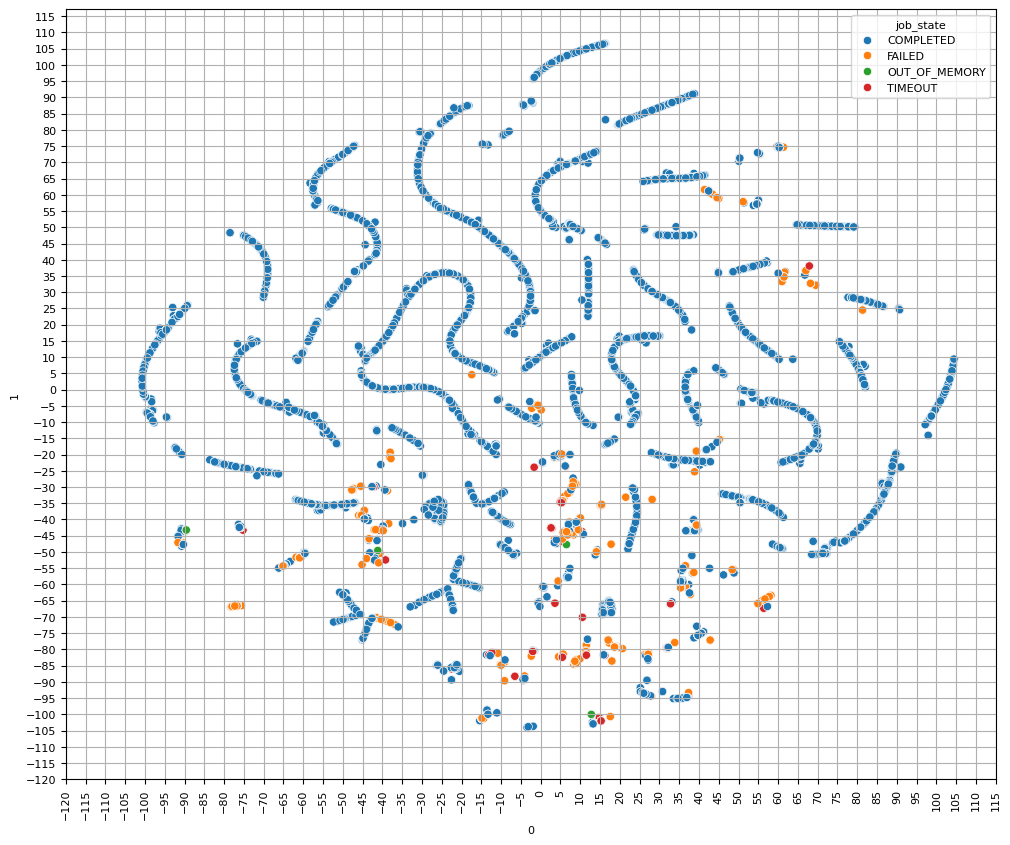

,0,1
0,-47.060387,53.292568
1,-56.627403,65.669510
2,-57.130131,-8.017166
3,42.381065,61.337788
4,-48.453026,53.934402
...,...,...
9995,68.033195,50.573772
9996,75.685944,50.250347
9997,79.092575,50.099606
9998,-76.159248,-42.416382


In [18]:
show_space(df_train_lda[:10000], labels_train[:10000], 2)

3D visualisation

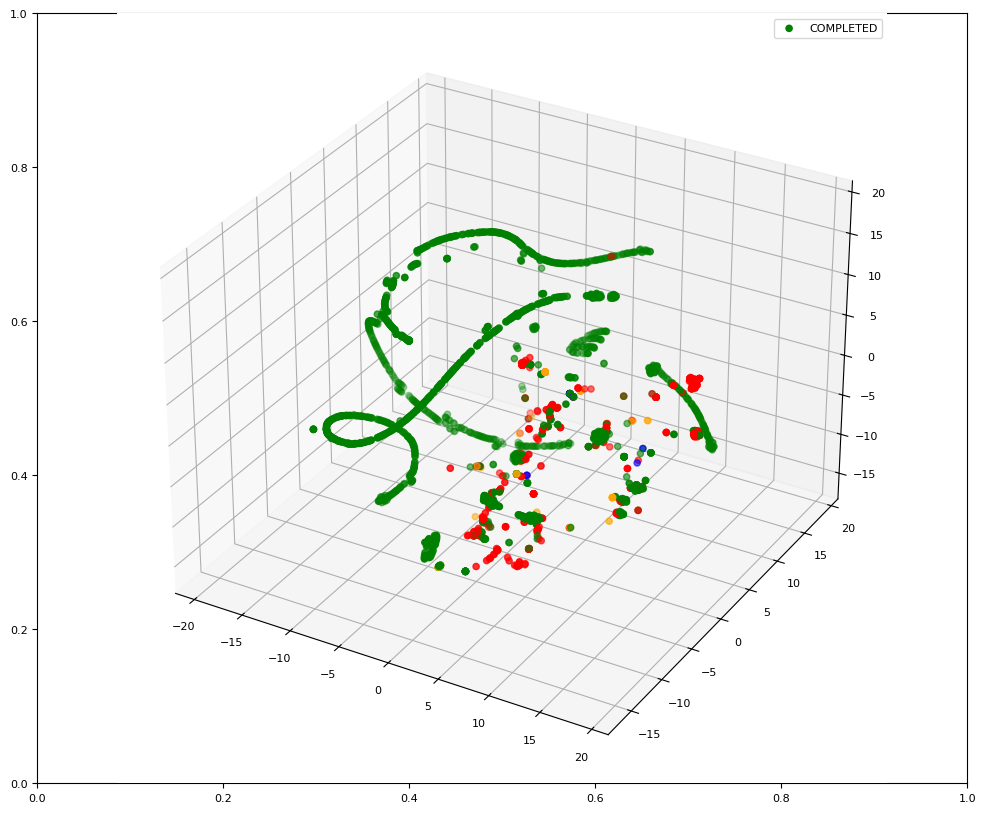

,0,1,2
0,-3.515950,4.430627,17.220362
1,-2.041538,11.574971,9.649671
2,-5.996519,7.577717,-12.147549
3,0.612982,1.740538,4.636067
4,-3.335747,5.151552,16.622595
...,...,...,...
1995,14.638485,9.749157,-5.415422
1996,-9.196889,-5.658461,-1.063293
1997,-0.294243,14.779516,-1.183473
1998,7.475378,-5.168596,5.706536


In [19]:
show_space(df_train_lda[:2000], labels_train[:2000], 3)

At this point, we se LDA transformed dataset trying to improve the performances of the multiclass classifier. So, we take the best model whose been trained on standard data, i.e. the MultiBinaryClassifier and we train it on LDA data.

At the end we compare the 2 models performance on test set

In [38]:
xgb_params = {'max_depth': 86, 'min_child_weight': 7, 'objective': 'multi:softmax', 'booster': 'gbtree', 'random_state': 42, 'n_jobs': -1, 'learning_rate': 0.1}

lab_enc = LabelEncoder()
labels_train = lab_enc.fit_transform(labels_train)

xgb_mc = XGBClassifier(**xgb_params)
xgb_mc.fit(df_train_lda, labels_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=86, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [42]:
df_test_lda = lda.transform(df_test)
labels_test = lab_enc.transform(labels_test)

train_pred = xgb_mc.predict(df_train_lda)
test_pred = xgb_mc.predict(df_test_lda)

print('*'*90+' Train set '+'*'*90)
print(classification_report(labels_train, train_pred, target_names=lab_enc.classes_))
print('*'*90+' Validation set '+'*'*90)
print(classification_report(labels_test, test_pred, target_names=lab_enc.classes_))

****************************************************************************************** Train set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.97      0.99      0.98    600300
       FAILED       0.87      0.78      0.82     69609
OUT_OF_MEMORY       0.76      0.59      0.66      2923
      TIMEOUT       0.79      0.70      0.74      9787

     accuracy                           0.96    682619
    macro avg       0.85      0.76      0.80    682619
 weighted avg       0.96      0.96      0.96    682619

****************************************************************************************** Validation set ******************************************************************************************
               precision    recall  f1-score   support

    COMPLETED       0.96      0.98      0.97    257683
       FAILED       0.82      0.72      0.77     29496
OU

LDA not improve the results. This is what we expect from the plots above, where data are not better separable compared to the original. This is another confirm that data are very complex and hard to predict.

### RF data analysis

In [4]:
labels[labels == "OUT_OF_MEMORY"] = "FAILED"
labels[labels == "TIMEOUT"] = "FAILED"

label_enc = LabelEncoder()
labels = label_enc.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(df, labels, test_size=0.3, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [5]:
weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weight = {k:v for k,v in enumerate(weight)}

features_ranking = {}
model = RandomForestClassifier(class_weight=weight, random_state=seed, n_jobs=-1)
for i in range(len(x_train.columns)):
  print("Iteration number: ", i)
  local_ranking = rf_feature_importance(model, x_train, y_train, x_test, y_test)
  column_to_drop = list(local_ranking.keys())[0]
  features_ranking.update({(99-i) : column_to_drop})
  x_train.drop(column_to_drop, axis='columns', inplace=True)
  x_test.drop(column_to_drop, axis='columns', inplace=True)

Iteration number:  0
-------------------------------------------------------------------
F1 on test set: 0.8525863184687729
Recall on test set: 0.8501778134679362
Precision on test set: 0.8550085085518156
Local ranking:  {'group_id': 2.149370879186364e-05, 'partition': 0.0008583584200315543, 'qos': 0.0011051789819807379, 'req_node': 0.009192394612618459, 'cpus_per_task': 0.01690927247116178, 'num_tasks': 0.026423613588511724, 'req_cpu': 0.026770219318589764, 'req_billing': 0.028289901041386338, 'req_gpu': 0.028766944877148662, 'req_mem': 0.044247654021049715, 'name': 0.07834910255566492, 'time_limit': 0.10542432862669675, 'priority': 0.11019535654432659, 'user_id': 0.12427916206580553, 'submit_time': 0.1937911395991445, 'command': 0.20537587956709108}
-------------------------------------------------------------------
Iteration number:  1
-------------------------------------------------------------------
F1 on test set: 0.8522537562604341
Recall on test set: 0.8491740277618447
Precisi

In [6]:
df = pd.read_pickle('data/job_table_reduced.pkl')

In [31]:
failed_mask = df['job_state'].apply(lambda v: v != "COMPLETED")
failed_command = df[failed_mask]['command']
print('Number of failed job:', len(failed_command))

num_contain_test = [command for command in failed_command if 'test' in command.lower()]
print('Number of job containing test word:', len(num_contain_test))

Number of failed job: 117187
Number of job containing test word: 16126


In [32]:
failed_command[:1000].values

array(['/m100_scratch/userexternal/squlagha/CaB3C3/job_CINECA.sh',
       '/m100_scratch/userexternal/spiccini/Tests_ASE/test_ga_qe/tmp_job_file.job',
       '/m100_scratch/userexternal/sataei00/wte2/pbe0/cellparam-pbe/k16/job_rpa.sh',
       '/m100_scratch/userexternal/msoler00/Cov/MD-muts/complex3/run1.pbs',
       '/m100_work/IscrC_LBE3D_0/f4861l/gpu_good.sh',
       '/m100_scratch/userexternal/sdelpupp/Gr@carbide@Ni/Ni_carbide/Ni_carbide.cmd',
       '/m100_work/IscrC_LBE3D_0/Elham/mut/f48_m/gpu.sh',
       '/m100_scratch/userinternal/dmolina1/ticket9848/TEMPLATE/ele_0.sh',
       '/m100_scratch/userexternal/spiccini/Tests_ASE/test_ga_qe/tmp_job_file.job',
       '/m100_work/IscrB_SPHERE/test/SnO/20201/yambo_calc/sbatch_yambo_calc',
       '/m100_work/IscrC_LBE3D_0/Elham/mut/f48_m/gpu.sh',
       '/m100_work/Pra20_CV48/STEFAN/TPC2_AC/SIM_04/MIN.x',
       '/m100_scratch/userinternal/faffinit/m100-test/CNT10POR8/job.slrm',
       '/m100/home/userexternal/agautier/WT/namd.slurm',
   

In [52]:
df = pd.read_pickle('/home/matteo/github/job_exit_state/data/job_table_preproc.pkl')
df = df.drop(columns=['command'])
labels = df.pop('job_state')
labels = labels.rename({'OUT_OF_MEMORY': 'FAILED', 'TIMEOUT': 'FAILED'})
labels = [int(lbl == 'FAILED') for lbl in labels.to_numpy()]

x_train, x_test, y_train, y_test = train_test_split(df.to_numpy(), labels, test_size=0.3, random_state=seed)

x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
weight = {k:v for k,v in enumerate(weight)}

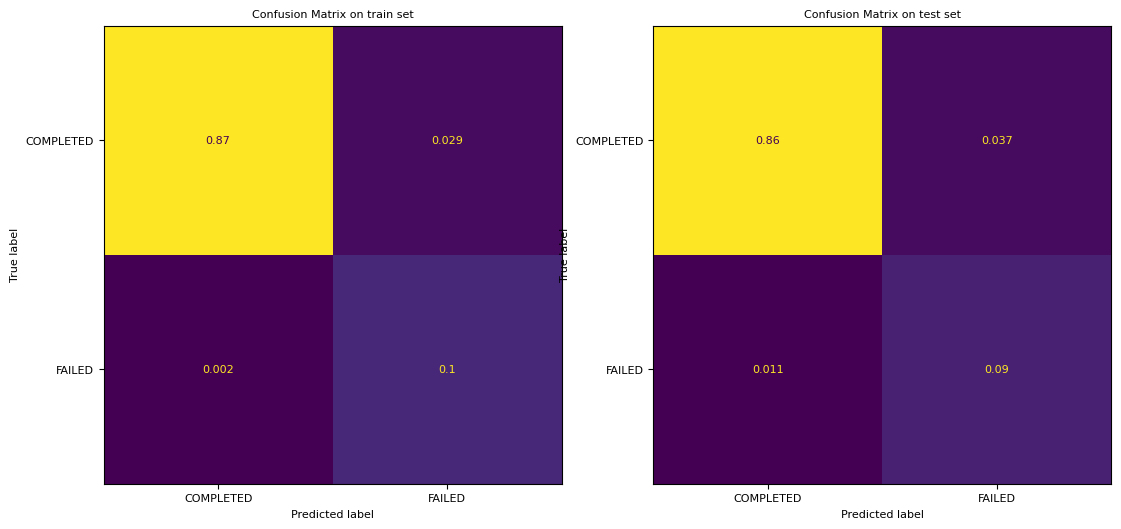

****************************************************************************************** Train set ******************************************************************************************
              precision    recall  f1-score   support

   COMPLETED       1.00      0.97      0.98    613010
      FAILED       0.78      0.98      0.87     69609

    accuracy                           0.97    682619
   macro avg       0.89      0.97      0.92    682619
weighted avg       0.98      0.97      0.97    682619

****************************************************************************************** Test set ******************************************************************************************
              precision    recall  f1-score   support

   COMPLETED       0.99      0.96      0.97    263055
      FAILED       0.71      0.89      0.79     29496

    accuracy                           0.95    292551
   macro avg       0.85      0.92      0.88    292551
weighted avg      

In [53]:
rf_no_command = RandomForestClassifier(class_weight=weight, random_state=seed, n_jobs=-1)
rf_no_command.fit(x_train, y_train)

train_pred = rf_no_command.predict(x_train)
test_pred = rf_no_command.predict(x_test)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
print_confusion_matrix(y_train, train_pred, 'binary', ax1)
ax1.set_title("Confusion Matrix on train set")
print_confusion_matrix(y_test, test_pred, 'binary', ax2)
ax2.set_title("Confusion Matrix on test set")
plt.show()

print('*'*90+' Train set '+'*'*90)
print(classification_report(y_train, train_pred, target_names=['COMPLETED', 'FAILED']))
print('*'*90+' Test set '+'*'*90)
print(classification_report(y_test, test_pred, target_names=['COMPLETED', 'FAILED']))

# Conclusion

Overall, the task was approached correctly and in fact all our expectations were reflected in the results. Having extensively inspected the data and seeing the conflict zones in the plots performed, we are all in all satisfied with the performance achieved in terms of F1 scores. 

As we imagined, when dealing with a task composed of tabular data, the best results come from classical machine learning methodologies. On the other hand, deep learning models struggle to understand how to divide the data in order to perform good classification, especially in a non-small dimensional space as in the case of our dataset.

The most balanced and correct classifications were obtained with ....... being the best model. ..........
.......

Unfortunately, higher scores could not be achieved due to the intrinsic nature of the data. Through visualisation using LDA, however, we discovered that it is only certain areas that have a high frequency of conflicts. 

This aspect would deserve further study and investigation in the search for these properties that unite completed and failed jobs. It must be pointed out that for computational and visual reasons, the plots comprise a tiny part of the total set of samples, so considerations are based solely on assumptions of repeatability.

 These observations may provide a starting point for more substantial future work that will certainly require more time than we have available. If we better understand the motivations and characteristics that create conflict (or missing characteristics that create confusion), it would be possible to insert constraints at the submit stage in order to limit failed jobs and their management once entered into the system.